# Scope analysis 

## Imports and other required functions

In [623]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import datetime
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
from scipy.signal import argrelextrema
from scipy.stats import norm
from lmfit.models import SkewedGaussianModel


#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_wavefromloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_wavefromloc ="A:/DATA/waveforms/"
    env_var_waveformloc_old="C:/Users/KK_Lab28_1/Documents/Waveforms/"
    data_dir_mod_old=""

elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_wavefromloc ="data/waveforms/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"
##############################

waveform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


#Read in runlist and change cols to numbers
def ReadRunlist(filename="C:/Users/jasonbane/Desktop/nexo_code/Run Data (GUI v1)/RunList.csv"):
    return pd.read_csv(filename,index_col=False)

Runlist_DF = ReadRunlist()
Runlist_DF["RN"]=Runlist_DF["Run No."]
number_cols=["Anode V.","Anode Grid V.","Cathode V.","Cathode Grid V.","Drift Length"]
Runlist_DF[number_cols] = Runlist_DF[number_cols].apply(pd.to_numeric)

# Read in Drift stack measurment database for drift, ext, col lengths and errors
Distance_Database=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/CellDistanceDataBase.csv")
Distance_Database["Date"] = Distance_Database["Date"].astype(str)
Distance_Database["Date"] = pd.to_datetime(Distance_Database["Date"])


# Add in distance to run list and calc fields
if 1==1:
#def runlist_distance_fix():
    global Runlist_DF
    global Distance_DataBase

    skip=0
    for i,run in enumerate(Runlist_DF["Run No."][skip:]):
        
        Date = pd.to_datetime(Runlist_DF["Date"].iloc[i+skip],format='%Y%m%d')
        # Date = datetime.datetime(Date)
        
        DF =Distance_Database[Distance_Database["Date"]<= Date].iloc[0]
        

        for key in DF.keys()[1:]:
            
            Runlist_DF.loc[i+skip,key] = DF[key]



Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)


#Bg database
bgdb=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/bg_db.csv")


#make blank dataframe for background subtraction debugging
blankBG_DF= pd.DataFrame({"Avg Anode":[0]*50000})

### Functions for fitting, Runinfo and waveform gathering

In [796]:
# Gaussian function definition
def congaussian(x,A,t,sigma):
    return A * np.exp(-(x-t)/0.42)* np.exp(-(x-t)**2/(2*sigma**2))

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
def logarithmic_model(x, a, b):
    return a * np.log(b * x)

def dg(x,a,mu_a,sigma_a,m,b):
    return a * np.exp(-(x - mu_a) ** 2 / (2 * sigma_a ** 2)) +   (m + x*b)

# Define a sinusoidal function for fitting
def sinusoidal(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset


# Define the skewed Gaussian function
def skewed_gaussian(x, alpha, mu, sigma, amplitude):
    # Standard normal PDF
    pdf = amplitude * (2 / sigma) * norm.pdf((x - mu) / sigma)
    # Skew factor
    cdf = norm.cdf(alpha * (x - mu) / sigma)
    return pdf * cdf

def errfunc(x, a, b, z, f):
    return a * scipy.special.erf((x - z)*f) + b

#Function to retrieve run list information
def GetRunInfo(runnumber, old=False):
    global Runlist_DF
    if old:
        print("not set up yet")
        return -1
    
    DF=Runlist_DF.query('`Run No.`== %f'%(runnumber))

    if len(DF)==0:
        print("That run is not in the list")
        return 0
    else:
        return DF
    

def GetBGRun(run):
    global bgdb
    try:
        return bgdb.query("run==%i"%(run)).iloc[0]["background"]
    except:
        return -1

In [5]:
def GetWaveForm(runnumber,wavenumber=9):
    global waveform_path
    RI = GetRunInfo(runnumber) 
    if type(RI)==type(0): #Make sure run is in runlist
        return 0
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(runnumber)

    # For left PC
    waveform_dir=waveform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="%s"%(wavenumber)

    waveform_filename=waveform_date+"-"+runnumber+"_"+"*"+waveform_wavenumber
    waveform_fullpath_wild=waveform_dir+"/"+waveform_filename+".csv"
    try: 
        waveform_fullpath=glob.glob(waveform_fullpath_wild )[-1].replace("\\","/")
    except:
        waveform_fullpath=glob.glob(waveform_dir+"/"+waveform_date+"-"+runnumber+"_"+"*" )[-1].replace("\\","/")
    
    if os.path.exists(waveform_fullpath):
        # Grab the second line and define the units of each column
        unit_line=open(waveform_fullpath).readlines()[1]
        units=unit_line.replace("(","").replace(")","").strip().split(",")
        #Build DF from csv
        DF=pd.read_csv(waveform_fullpath,skiprows=[1])
        # Convert to ms and mV
        for i,key in enumerate(DF.keys()):
            if units[i] == "V":
                DF[key]=DF[key]*1000 
            if units[i] == "ms":
                print("time convertion")
                DF[key]=DF[key]*1000 
        # rename columns
        DF=ReNameCols(DF)
        return DF
    else: # Did not find file
        print("Issue with file")
        return 0
    

# this should correct the colomn names of the avg cath and anode. need to add incorrect options to list
def ReNameCols(DF):
    chann_name_options=[["Avg UV","Avg Anode"],
                        ['Average Cathode (2)', 'Average Anode (2)'],
                        ['average(Cathode)', 'average(Anode)']]
    Correct_names=["Avg Cathode","Avg Anode"]
    keys=DF.keys()
    if Correct_names[0] in keys and Correct_names[1] in keys:
        return DF
    for chan_options in chann_name_options:
        if chan_options[0] in keys:
            DF =DF.rename(columns={chan_options[0]: Correct_names[0]})
        if chan_options[1] in keys:
            DF =DF.rename(columns={chan_options[1]: Correct_names[1]})

    return DF






In [6]:
analysis_list=[]

## Building fitting and plotting functions for a run

In [7]:
#Will need to make argruments
debug =0
plot = True
savefig=True


runlist=[375]
#bg_runs=[335]

stepcount=100
diffsizes =[200]


In [687]:


# for k,diffsize in enumerate(diffsizes):
#     i=0
#     for j,run in enumerate(runlist):
def AnalyzeRun(runs=[200],stepcounts=[100],diffsizes=[200],debug=1,plot=True,savefig=True):

    anode_delay=[]
    cathode_delay=[]
    drift_field_list=[]
    k=0
    ana_list=[]
    if type(runs)==type(1):
        runs=[runs]
    if type(stepcounts)==type(1):
        stepcounts=[stepcounts]
    if type(diffsizes)==type(1):
        diffsizes=[stepcounts]
    
    for run in runs:
        for diffsize in diffsizes:
            for stepcount in stepcounts:
            

                analysis_dict={}
                bg_run=GetBGRun(run)
                if debug >= 1: 
                    print("Run " , run, "  BG- ", bg_run)
                    print("Stepsize %i , DiffSize %i"%(stepcount,diffsize))
                
                
                # Grab the main and background waveforms
                try:
                    DF=GetWaveForm(run)
                except:
                    print("Issue with run " ,run)
                    continue
                try:
                    if bg_run ==-1:
                        n=len(DF["Time"])
                        bgDF=pd.DataFrame({"Avg Cathode": [0] *n , "Avg Anode": [0] * n})
                    else:
                        bgDF=GetWaveForm(bg_run)
                except Exception as e:
                    print(f"An error occurred: {e}")
                    print("Issue with bg " , bg_run)
                    continue

                
                    
                timeresolution = np.round(DF["Time"].iloc[1] - DF["Time"].iloc[0],5)
                if debug >=4: print("Time step size: ", round(timeresolution,5))
                RI = GetRunInfo(run)
                drift_field=RI["Drift Field"].iloc[0]
                bgRI = GetRunInfo(bg_run)

                # Find the baseline normalization of each waveform
                mod_step=int((stepcount * np.round(0.004/timeresolution,4)))
                res_mod=np.round(0.004/timeresolution,3)
                Zero_time = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] #Time 0
                if debug >=10: print("Mod step %i, res mod %0.4f, Zero time index %i, Zero time %0.4f"%(mod_step,res_mod,Zero_time,DF["Time"].iloc[Zero_time]))
                #Get Normalizations for setting baseline to zero

                anodenorm=np.average(DF["Avg Anode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                cathnorm =np.average(DF["Avg Cathode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                bg_anorm =np.average(bgDF["Avg Anode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                bg_cnorm =np.average(bgDF["Avg Cathode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])

                #Normalize signal and BG then subtract, make correct o bg if too big
                bg_y_factor=1
                anode_sig=DF["Avg Anode"] - anodenorm
                bg_a_sig_full =bgDF["Avg Anode"] - bg_anorm

                DF["Avg Anode Norm"]=anode_sig
                DF["Smooth Anode Norm"]=np.convolve(DF["Avg Anode Norm"],np.ones(stepcount)/stepcount,mode="same")
                # Get Noise BG
                if debug >=5:
                    print("starting sin removal")
                Anode_sin_params,Anode_sin_covariance=GetSinBG(DF["Time"]
                        ,DF["Avg Anode Norm"],
                        time_start=26,time_stop=50,debug=1,stepsize=stepcount)
                if debug >=5:
                    print("starting sin removal for bg")
                AnodeBG_sin_params,AnodeBG_sin_covariance=GetSinBG(DF["Time"]
                        ,bg_a_sig_full[:len(DF["Time"])],
                        time_start=26,time_stop=50,debug=1,stepsize=stepcount,plot=True)
                

                DF["Anode Signal"]=  DF["Smooth Anode Norm"] - sin(DF["Time"],Anode_sin_params[0],Anode_sin_params[1],Anode_sin_params[2])
                DF["BG Signal"] = bg_a_sig_full- sin(DF["Time"],AnodeBG_sin_params[0],AnodeBG_sin_params[1],AnodeBG_sin_params[2])
                DF["Smooth BG Signal"]=np.convolve(DF["BG Signal"],np.ones(stepcount)/stepcount,mode="same")
                # Get Noise BG        
                #DF["Smooth Anode Norm"]=np.convolve(DF["Avg Anode Norm"],np.ones(stepcount)/stepcount,mode="same")
                #split bg into 2 sections
                split_loc=Zero_time+500                
                bg_a_sig_1=bg_a_sig_full[:split_loc* int(0.004/timeresolution)]
                bg_a_sig_2=bg_a_sig_full[split_loc* int(0.004/timeresolution):]
                #roll the second bit
                bg_a_sig_2=bg_a_sig_2.rolling(mod_step*10,min_periods=1,center=True).mean()
                #bring them together
                bg_a_sig=np.concatenate([bg_a_sig_1,bg_a_sig_2])
                print("DF length ",len(DF["Time"]),"resolution", timeresolution)
                print("\n Time @ zero \t time @ 0 + 500")
                print(DF["Time"].iloc[Zero_time],"\t",DF["Time"].iloc[split_loc* int(0.004/timeresolution)] )
                print("")
                

                #bg_a_sig=bg_a_sig.rolling(mod_step*100,min_periods=1)#np.concatenate([bg_a_sig_fist_bit,bg_a_sig_last_bit])
                
                if np.max(bg_a_sig[:3000]) > np.max(anode_sig[:3000]):
                    if debug >=10: print("bg too big")
                    bg_y_factor= np.max(anode_sig[:3000])/np.max(bg_a_sig[:3000])
                if len(anode_sig) <= len(bg_a_sig):
                    anode_sub= anode_sig-bg_a_sig[:len(anode_sig)]*bg_y_factor
                if len(anode_sig) > len(bg_a_sig):
                    anode_sub= anode_sig[:len(bg_a_sig)]-bg_a_sig*bg_y_factor
                DF["Anode Sub"] = DF["Anode Signal"] - DF["Smooth BG Signal"]*bg_y_factor


                #take diff
                rolling= anode_sub.rolling(mod_step).mean()
                smooth_slice=slice(int(stepcount/2),-(int(stepcount/2)+1))
                DF["Smooth Anode Sub"] = np.convolve(DF["Anode Sub"],np.ones(stepcount)/stepcount,mode="same")

                if debug >=10: print("modifed diffsize ",int(diffsize*res_mod))
                
                anode_diff = rolling.diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])

                DF["Anode Diff"] =  DF["Smooth Anode Sub"].diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])
                anode_diff= DF["Smooth Anode Sub"].diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])
                


                if 1==1: fig, ax = plt.subplots(2,2, figsize=(12,7))

                #Plot 
                if 1==1:# plot: 
                    ax[0][1].errorbar(x=DF["Time"][::mod_step],y=DF["Anode Signal"][::mod_step],  label="Anode Signal")
                    if len(DF["Time"][::]) <= len(bg_a_sig_full):
                        ax[0][1].errorbar(x=DF["Time"][::],y=bg_a_sig_full[:len(DF["Time"][::])]*bg_y_factor,  label="BG")
                    if len(DF["Time"][::]) > len(bg_a_sig_full):
                        ax[0][1].errorbar(x=DF["Time"][:len(bg_a_sig_full):],y=bg_a_sig_full[::]*bg_y_factor,  label="BG")
                    ax[0][1].errorbar(x=DF["Time"][::],y=DF["Smooth BG Signal"]*bg_y_factor,  label="Background")                   
                    ax[0][1].errorbar(x=DF["Time"][::],y=DF["Anode Sub"][::],  label="Subtracted")
                    #ax[0][1].errorbar(x=DF["Time"][::stepcount],y=DF["Smooth Anode Sub"][::stepcount],  label="Smooth Subtracted")

                    ax[1][1].errorbar(x=DF["Time"][int(stepcount):-int(stepcount):stepcount],y=DF["Anode Diff"][int(stepcount):-int(stepcount):stepcount],  label="Derivative")

                #Fit the derivative with a guassian
                fit_start_index = np.where(abs(DF["Time"] - 5) <= 10*timeresolution)[0][-1] 
                fit_stop_index = np.where(abs(DF["Time"] - 25) >= 10*timeresolution)[0][-1] 

                #P0 for guassian fit
                #P0 for amp
                print("fit start",fit_start_index,DF["Time"][fit_start_index])
                print("fit stop",fit_stop_index,DF["Time"][fit_stop_index])
                diff_max=np.max(anode_diff[fit_start_index:fit_stop_index]) #Amp value
                max_loc_ind = np.where(anode_diff == diff_max)[0] #index for max location
                max_time= np.array(DF["Time"])[max_loc_ind]    # time for the max location
                
                #P0 for sigma 
                half_max_ind=[]
                k=0
                while len(half_max_ind) <=1:
                    half_max_ind= (np.where(abs(anode_diff[fit_start_index:] - diff_max/2.0) <= 0.01*(k+1)) + fit_start_index)[0] #indexes for simga guess
                    k=k+1
                    if k >=5:
                        print("Cant find second half max for anode")
                        break
                try :
                    half_max_sep = DF["Time"].iloc[half_max_ind[-1]] - DF["Time"].iloc[half_max_ind[0]]  # seperation between first and last index
                except : 
                    half_max_sep = timeresolution*4 #why 4? Need to address !flag!
                
                #anode Fitting data
                sec_fit_ind = max_loc_ind[0]+int(np.floor(20/timeresolution))
                print("sec fit", max_loc_ind[0]+sec_fit_ind,DF["Time"][sec_fit_ind])
                xfit = np.array(DF["Time"][fit_start_index:sec_fit_ind])
                yfit = np.array(anode_diff[fit_start_index:sec_fit_ind].fillna(0))
                        
                p0 = [diff_max,max_time[0],half_max_sep/2]
                if debug >=5: print("Anode p0 ", np.round(p0,4))
                
                # Set up to loop through a few fitting attempts
                max_fits, sigma,A,z= 5,10,0,0
                Amp=diff_max    
                xfit_tmp=xfit
                yfit_tmp=yfit
                anode_bounds=[[Amp*0.25,p0[1]*0.75,0],[Amp*2,p0[1]*1.25,p0[2]*2]]
                while sigma >=1 or abs((A-Amp))/Amp >= 0.1:

                    ppot, pcov = curve_fit(gaussian,xfit_tmp,yfit_tmp, p0=p0,maxfev = 2000,bounds=anode_bounds)
                    z=z+1
                    sigma=ppot[2]
                    A=ppot[0]
                    if sigma <= 1 and abs((A-Amp))/Amp <= 0.1:
                        if debug>=5: 
                            print("Good fit, attempts",z)
                            print("Sigma ",sigma)
                            print("amp ",A)
                            print("mu ",ppot[1])

                        break

                    if z >=max_fits:
                        break

                    #adjust fitting range to attempt a new fit
                    first_index=np.max([max_loc_ind[0]-(max_fits+2-z)*500,fit_start_index])
                    last_index=np.min([max_loc_ind[0]+(max_fits+2-z)*500,sec_fit_ind])

                    if debug>=10:
                        print("old Results")
                        print("Sigma ",sigma)
                        print("amp ",A)
                        print( "(guess-A)/A ",abs((A-Amp))/Amp)
                        print("mu ",ppot[1])


                        print("new Fit ",z)
                        print("last index",last_index, " Time ", DF["Time"][last_index] )
                        print("first index",first_index, "time", DF["Time"][first_index] )


                    yfit_tmp = anode_diff[first_index:last_index+1]
                    xfit_tmp = DF["Time"].iloc[first_index:last_index+1]
                    # print(xfit_tmp)
                    print("Fitting limits", xfit_tmp[first_index],xfit_tmp[last_index])
                    

                #End of fitting loop for anode

                if ppot[0] <0:
                    print("Bad fit skipping run ", run)
                    continue

                
                fig2,bx=plt.subplots(figsize=(5,4))        
                #plot the guassian
                if 1==1:#plot: 

                #Find the values use to determine the anode amplitude
                    avg_len=int(2.5/timeresolution)
                    alen_min=int(.5/timeresolution)
                    backsteps=int(1./timeresolution)
                    avg_min_1=max_loc_ind[0]-backsteps-alen_min
                    avg_min_2=max_loc_ind[0]-backsteps
                    anode_avg_AM=np.average(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min=np.average(DF["Smooth Anode Sub"][avg_min_1:avg_min_2])
                    anode_signal_with_sub=anode_avg_AM-anode_avg_min
                    avg_max_array=anode_avg_AM*np.ones(len(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len]))
                    avg_min_array=anode_avg_min*np.ones(len(DF["Smooth Anode Sub"][avg_min_1:avg_min_2]))

                    anode_avg_AM_notsub=np.average(DF["Anode Signal"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min_notsub=np.average(DF["Anode Signal"][avg_min_1:avg_min_2])

                    avg_max_array_notsub=anode_avg_AM_notsub*np.ones(len(DF["Anode Signal"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len]))
                    avg_min_array_notsub=anode_avg_min_notsub*np.ones(len(DF["Anode Signal"][avg_min_1:avg_min_2]))
                    anode_signal_notsub=anode_avg_AM_notsub-anode_avg_min_notsub

                    bx.errorbar(DF["Time"],DF["Smooth Anode Sub"])
                    bx.errorbar(DF["Time"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len],
                        avg_max_array,
                        fmt=" ",marker="s",alpha=0.5,markersize=5,label="Max Sig.")
                    bx.errorbar(DF["Time"][avg_min_1:avg_min_2],
                        avg_min_array,color="red",
                        fmt=" ",marker="s",alpha=0.5,markersize=5,label="Min Sig.")
                    
                    bx.errorbar(DF["Time"],DF["Anode Signal"])
                    bx.errorbar(DF["Time"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len],
                        avg_max_array_notsub,alpha=0.5,color="Orange",
                        fmt=" ",marker="s",markersize=5,label="Max Sig.")
                    bx.errorbar(DF["Time"][avg_min_1:avg_min_2],
                        avg_min_array_notsub,alpha=0.5,color="red",
                        fmt=" ",marker="s",markersize=5,label="Min Sig.")
                    bx.grid()
                    bx.set_xlabel("Time[us]")
                    bx.set_ylabel("[mV]")

                    print("anode strength, with/w/o", anode_signal_with_sub,anode_signal_notsub)
                    
                    
                    guass_y = gaussian(xfit_tmp,ppot[0],ppot[1],ppot[2])
                    ax[1][1].errorbar(x=xfit_tmp,y=guass_y,fmt="--",
                                    label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

                ap0=p0
                appot=ppot    
                apcov=pcov
##########################################
##########################################
##########################################
                #Cathode analysis
                #Normalize signal and BG then subtract
                cath_sig=DF["Avg Cathode"] - cathnorm
                diff_time_size=(DF["Time"].iloc[int(diffsize*res_mod)]-DF["Time"].iloc[0])
                cath_diff = cath_sig.diff(int(diffsize*res_mod))/diff_time_size
                
                if 1==1:#plot: 
                    ax[0][0].errorbar(x=DF["Time"][::mod_step],
                                    y=cath_sig[::mod_step],   label="Cathode Signal")

                    ax[1][0].errorbar(x=DF["Time"][::mod_step],y=cath_diff[::mod_step],   label="Derivative")
                
                #Cathode Fitting data
                xfit = np.array(DF["Time"][:])
                yfit = np.array(cath_diff[:].fillna(0))
                
                #guess for cathode fit

                min_loc_ind = np.where(cath_diff == np.min(cath_diff)) #index for min locaiton
                min_time= np.array(DF["Time"])[min_loc_ind][0]

                k=0
                half_min_ind=[]
                while len(half_min_ind) <=1:
                    half_min_ind= (np.where(abs(cath_diff - np.min(cath_diff)/2.0) <= 0.2*k) )[0] #indexes for simga guess
                    k=k+1
                    if k >=45:
                        print("Cant find second half max")
                        break
                
                half_min_sep = DF["Time"].iloc[half_min_ind[-1]] - DF["Time"].iloc[half_min_ind[0]]  # seperation between first and last index
                
                
                p0 = [np.min(yfit),min_time,half_min_sep]
                if debug >=5: print("cathode p0", np.round(p0,4))
                #Fit cathode deriv
                ppot, pcov = curve_fit(gaussian,xfit,yfit, p0=p0)


                if 1==1:#plot:
                    guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
                    ax[1][0].errorbar(x=xfit,y=guass_y,fmt="--",
                                    label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

                    ax[1][0].grid()
                    ax[1][0].legend()
                    ax[1][0].set_xlabel("Time[us]")
                    ax[1][0].set_ylabel("Cathode Derivative [mV/us]")
                    ax[1][0].minorticks_on()
                    ax[1][0].set_xlim(-7.5,41.5)

                    ax[1][1].grid()
                    ax[1][1].legend()
                    ax[1][1].set_xlabel("Time[us]")
                    ax[1][1].set_ylabel("Anode Derivative [mV/us]")
                    ax[1][1].set_xlim(-7.5,41.5)

                    ax[0][0].grid()
                    ax[0][0].legend()#loc="upper right")
                    ax[0][0].set_xlabel("Time[us]")
                    ax[0][0].set_ylabel("Cathode Signal [mV]")
                    ax[0][0].set_xlim(-7.5,41.5)

                    ax[0][1].grid()
                    ax[0][1].legend()#loc="upper right")
                    ax[0][1].set_xlabel("Time[us]")
                    ax[0][1].set_ylabel("Anode Signal [mV]")
                    ax[0][1].set_xlim(-7.5,41.5)
                
                    fig.suptitle("Run %i\n %i %i"%(run,stepcount,diffsize))
                    plt.tight_layout()


                # Need to develop funciton to check if this fit needs to be replaced. !flag! 
                analysis_dict["Run"]=run
                analysis_dict["Anode P0"]=ap0
                analysis_dict["Anode Delay Time"] = appot[1]
                analysis_dict["Anode Delay Sigma"] = appot[2]
                #analysis_dict["Anode Amp"] = appot[0]

                analysis_dict["Anode Amp"] = anode_signal_with_sub
                analysis_dict["Anode Amp notsub"] = anode_signal_notsub
                

                analysis_dict["Cathode P0"]=p0
                analysis_dict["fit stepsize"]=stepcount
                analysis_dict["fit diffsize"]=diffsize
                analysis_dict["Cathode Delay Time"] = ppot[1]
                analysis_dict["Cathode Delay Sigma"] = ppot[2]
                analysis_dict["Cathode Amp"] = ppot[0]
                analysis_dict["Cathode Wave Amp"] = np.abs(np.min(cath_sig[::mod_step]) -np.max(cath_sig[::mod_step]))


                drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
                extract_field=RI["Extraction Field"].iloc[0]
                analysis_dict["Drift Field"] =drift_field
                analysis_dict["Extraction Field"] =extract_field
                analysis_dict["pressure"] = RI["Target Pressure"].iloc[0]
                analysis_dict["Temp"] = RI["RTD 2"].iloc[0]
                analysis_dict["Laser Current"] = float(RI["Laser Current"].iloc[0])
                analysis_dict["Laser Freq."] = float(RI["Laser Freq."].iloc[0])
                analysis_dict["Cathode V."] = float(RI["Cathode V."].iloc[0])
                analysis_dict["Drift Length"] = float(RI["Drift Length"].iloc[0])
                ana_list.append(analysis_dict)    
                if savefig:
                    plot_dir="C:/Users/jasonbane/Desktop/nexo_code/Plots/"
                    plot_filename="Run%i_stp%i_diff%i.png"%(run,stepcount,diffsize)
                    plot_fullpath=plot_dir+"/"+plot_filename
                    fig.savefig(plot_fullpath)
                if plot == False:
                    plt.close(fig2)
                    plt.close(fig)

    return ana_list









In [413]:
def DV_ana(DF):
    DF.loc[:,"Drift Vel"] = DF["Drift Length"]/(DF["Anode Delay Time"] -(DF["Cathode Delay Time"]))
    Avg_Vel_DF=DF.groupby("Run")["Drift Vel"].mean()
    Std_dev_DF=DF.groupby("Run")["Drift Vel"].std()
    DF["Avg Drift Vel"]= DF['Run'].map(Avg_Vel_DF)
    DF["Avg Drift Vel STD"]= DF['Run'].map(Std_dev_DF)
    return DF


Run  333   BG-  338
Stepsize 50 , DiffSize 1
Time step size:  0.004
Mod step 50, res mod 1.0000, Zero time index 2511, Zero time 0.0360
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03600005 	 2.036

bg too big
modifed diffsize  1
fit start 3762 5.03999991
fit stop 12501 39.99599892
sec fit 17606 35.20399906
Anode p0  [ 1.5055 15.204  11.238 ]
old Results
Sigma  0.3152620490872724
amp  1.1993593900483674
(guess-A)/A  0.20335379125251637
mu  15.090314448964255
new Fit  1
last index 9303  Time  27.20399928
first index 3762 time 5.03999991
Fitting limits 5.03999991 27.20399928
old Results
Sigma  0.3152649652372422
amp  1.1993538399984605
(guess-A)/A  0.20335747774236543
mu  15.090316031083068
new Fit  2
last index 8803  Time  25.20399934
first index 3803 time 5.20399991
Fitting limits 5.20399991 25.20399934
old Results
Sigma  0.31526393813499365
amp  1.199355794748111
(guess-A)/A  0.20335617934597888
mu  15.090315490405688
new Fit  3
last index 8303  Time  23.2039994


[{'Run': 333,
  'Anode P0': [1.5055106983237192, 15.20399962, 11.23799968],
  'Anode Delay Time': 15.090313108750916,
  'Anode Delay Sigma': 0.31525959328190367,
  'Anode Amp': 0.9884138240555063,
  'Anode Amp notsub': 0.693497946885334,
  'Cathode P0': [-136.120000000015, -9.71199967, 45.955998699999995],
  'fit stepsize': 50,
  'fit diffsize': 1,
  'Cathode Delay Time': 1.1923763514334413,
  'Cathode Delay Sigma': -0.6152859699592388,
  'Cathode Amp': -20.664707084292353,
  'Cathode Wave Amp': 31.090349999999994,
  'Drift Field': 401.7491392285555,
  'Extraction Field': 400.72261455082963,
  'pressure': 25.7,
  'Temp': 173.5,
  'Laser Current': 28.0,
  'Laser Freq.': 500.0,
  'Cathode V.': 913.2,
  'Drift Length': 20.90857}]

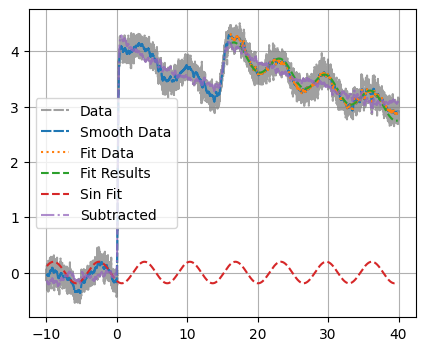

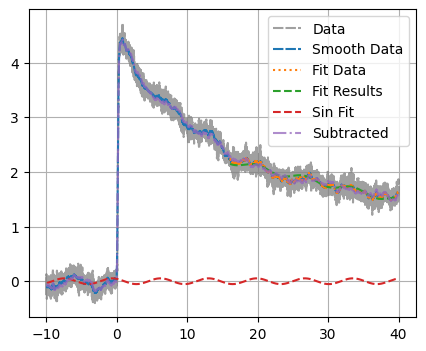

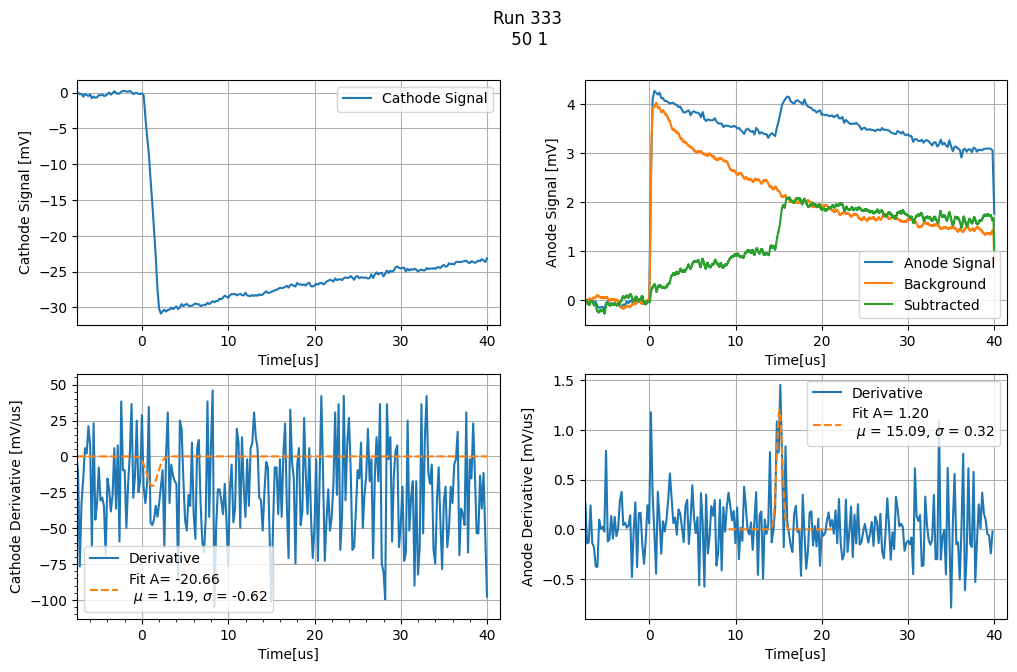

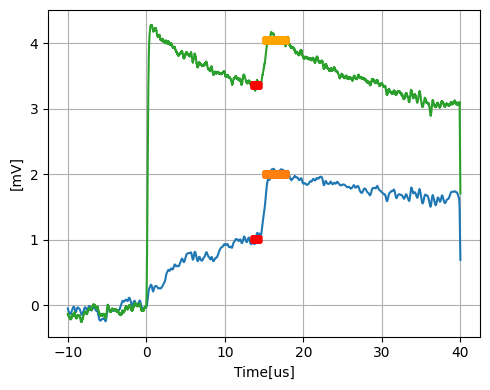

In [488]:
AnalyzeRun([333],[50],[1],debug=10)

Run  334   BG-  339
Stepsize 100 , DiffSize 100
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03800005 	 2.038

fit start 3761 5.03799991
fit stop 12501 39.99799892
sec fit 18172 36.33799903
Fitting limits 5.03799991 28.33799925
Fitting limits 6.33799987 26.33799931
Fitting limits 8.33799982 24.33799937
Fitting limits 10.33799976 22.33799942
anode strength, with/w/o 0.6678189209342572 0.612661387788688
Run  333   BG-  338
Stepsize 100 , DiffSize 100
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03600005 	 2.036

fit start 3762 5.03999991
fit stop 12501 39.99599892
sec fit 17648 35.28799906
anode strength, with/w/o 0.9724891802567754 0.6863232615380808
Run  332   BG-  337
Stepsize 100 , DiffSize 100
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03760005 	 2.0376

fit start 3761 5.03759991
fit stop 12501 39.99759892
sec fit 17350 34.69359907
anode strength, with/w/o 0.9934092863036561 0.5546061599817698
Run  331   BG-  336
St

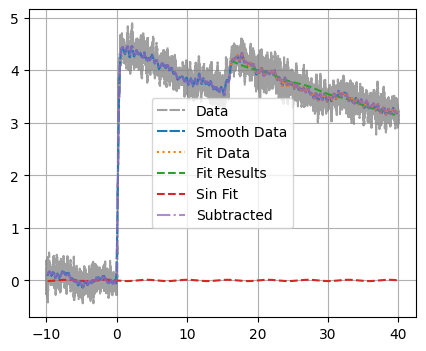

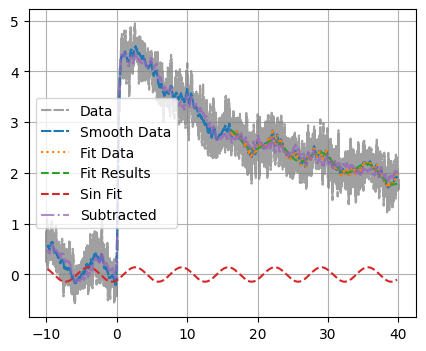

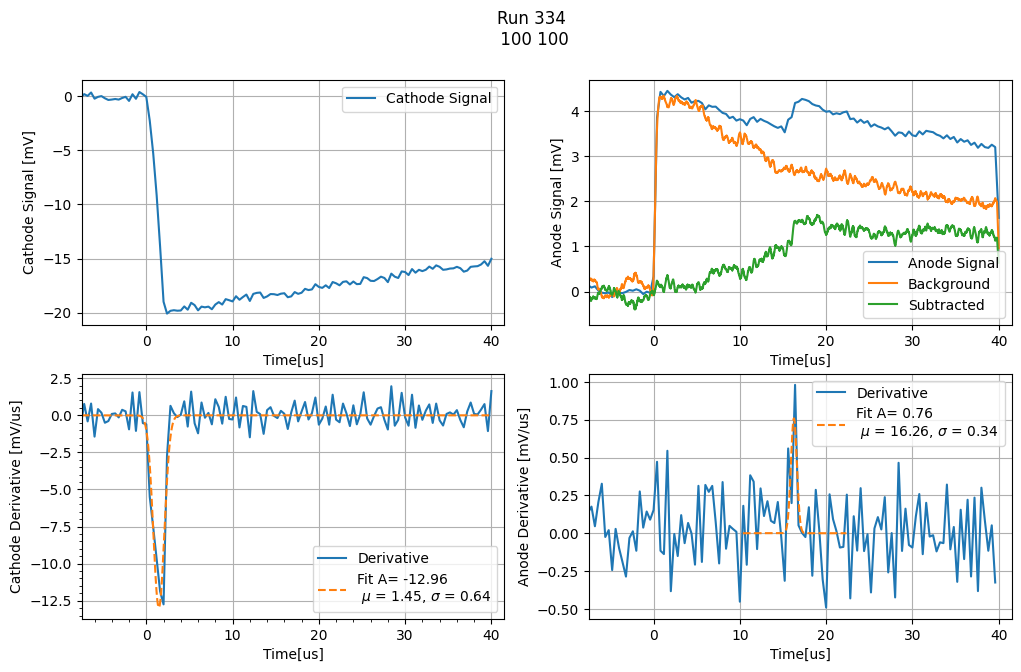

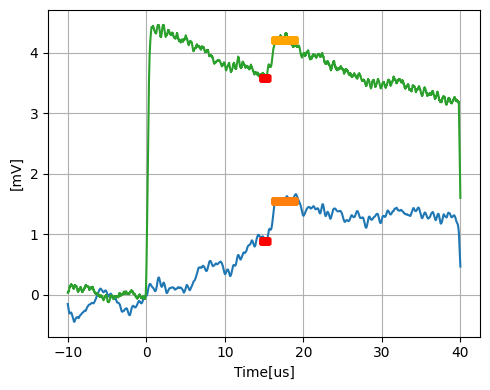

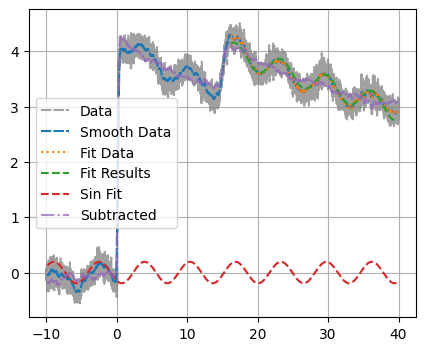

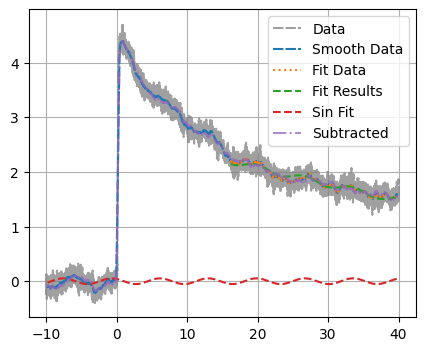

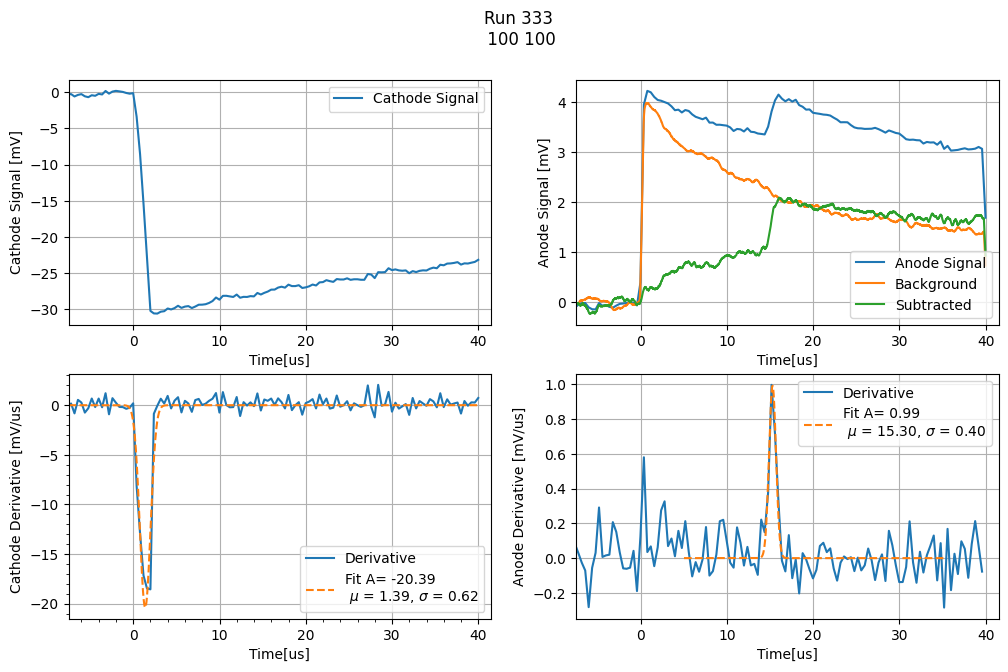

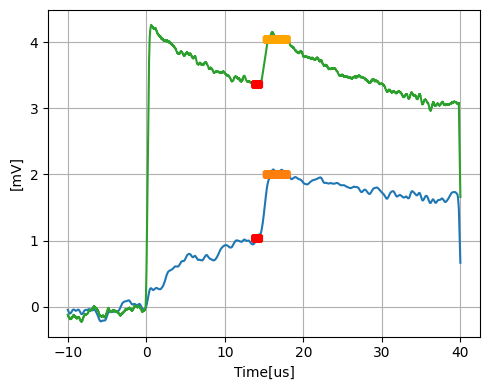

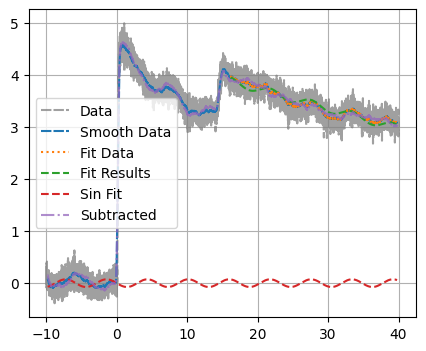

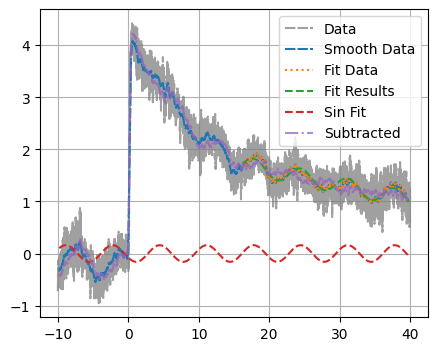

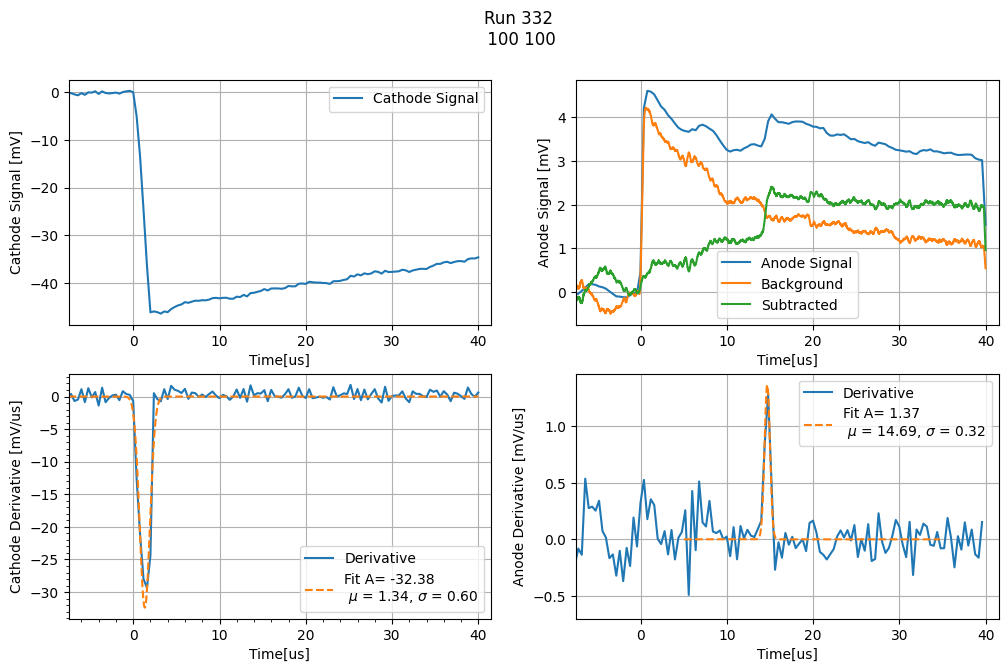

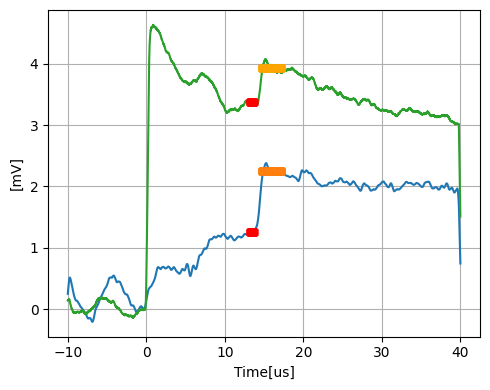

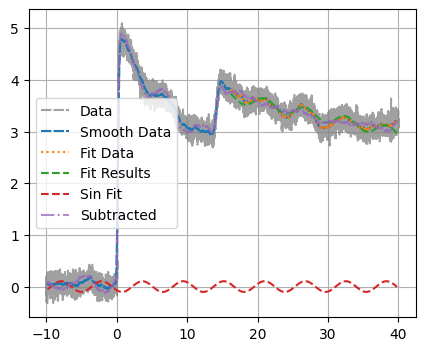

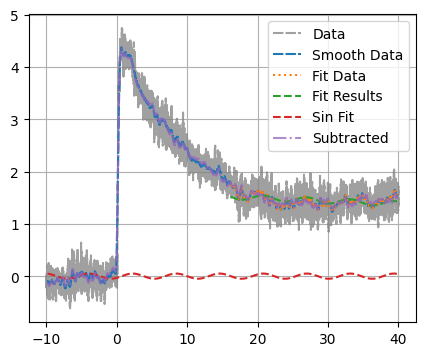

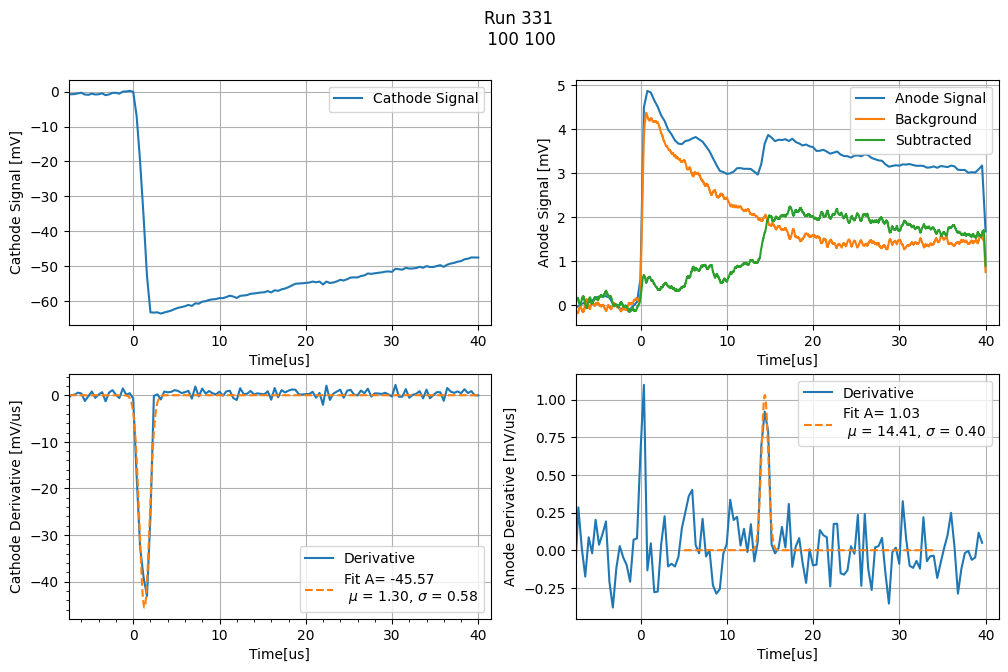

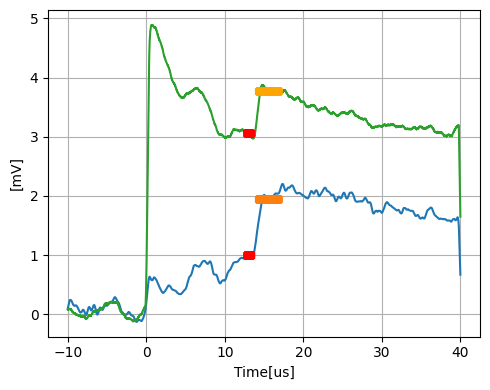

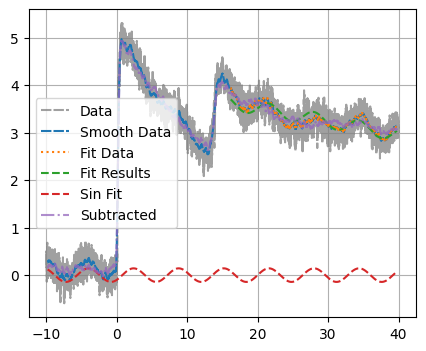

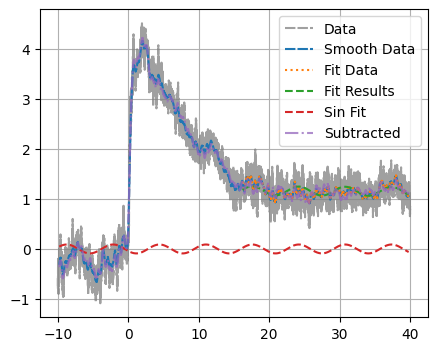

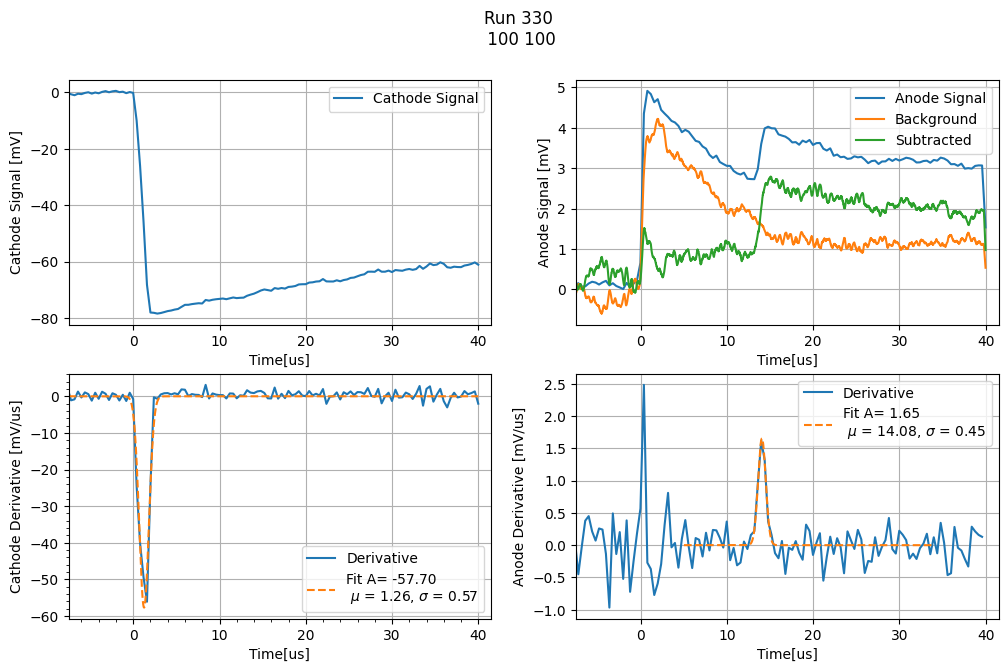

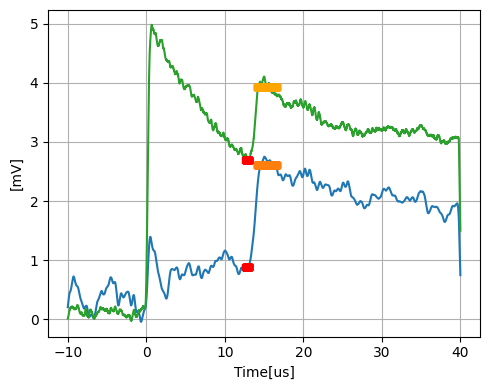

In [627]:
Nov01_DSweep_v3= AnalyzeRun([334,333,332,331,330],[100],[100],debug=1)



Run  385   BG-  394
Stepsize 100 , DiffSize 100
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03600005 	 2.036

fit start 3762 5.03999991
fit stop 12501 39.99599892
sec fit 16980 33.95199909
anode strength, with/w/o 2.172324993078422 1.7461186218721951
Run  386   BG-  393
Stepsize 100 , DiffSize 100
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03960005 	 2.0396

fit start 3761 5.03959991
fit stop 12501 39.99959892
sec fit 17190 34.37559908
anode strength, with/w/o 1.7710799657609706 1.5096908862948082
Run  387   BG-  392
Stepsize 100 , DiffSize 100
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03714291 	 2.03714285

fit start 3761 5.03714277
fit stop 12501 39.99714178
sec fit 17414 34.82114193
anode strength, with/w/o 1.529980797669698 1.3144037853841937
Run  388   BG-  391
Stepsize 100 , DiffSize 100
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03733339 	 2.03733333

fit start 3761 5.03733324
fit sto

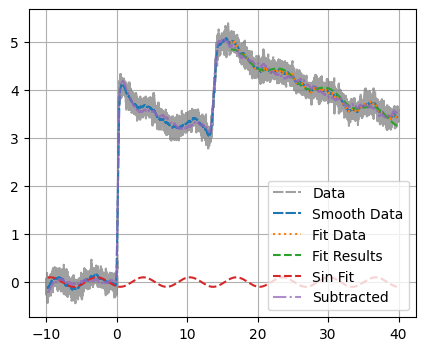

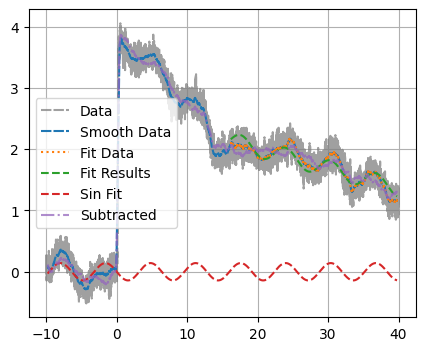

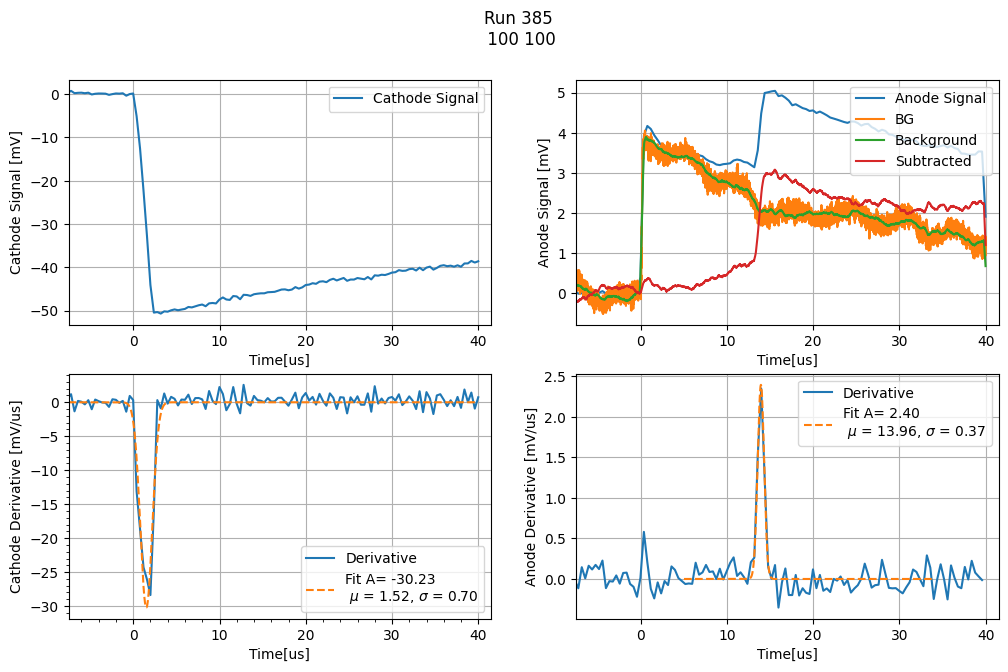

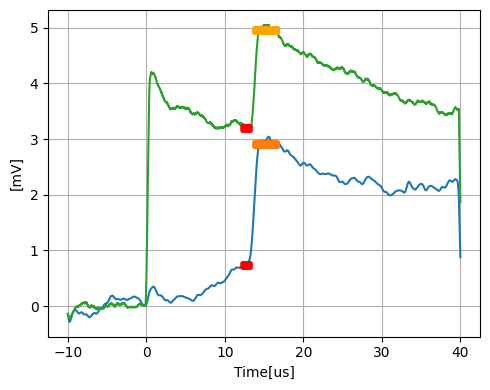

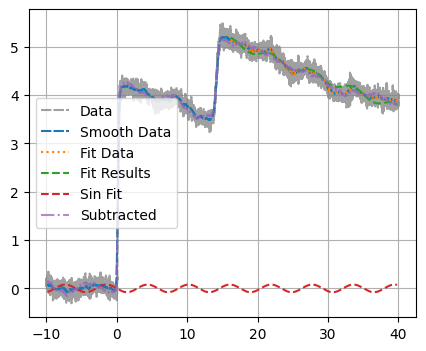

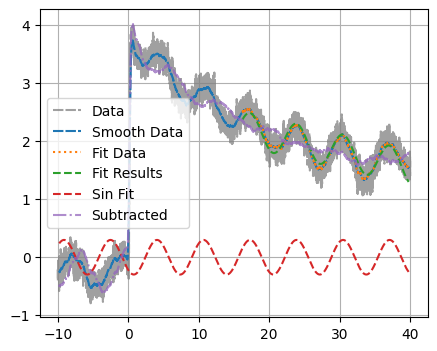

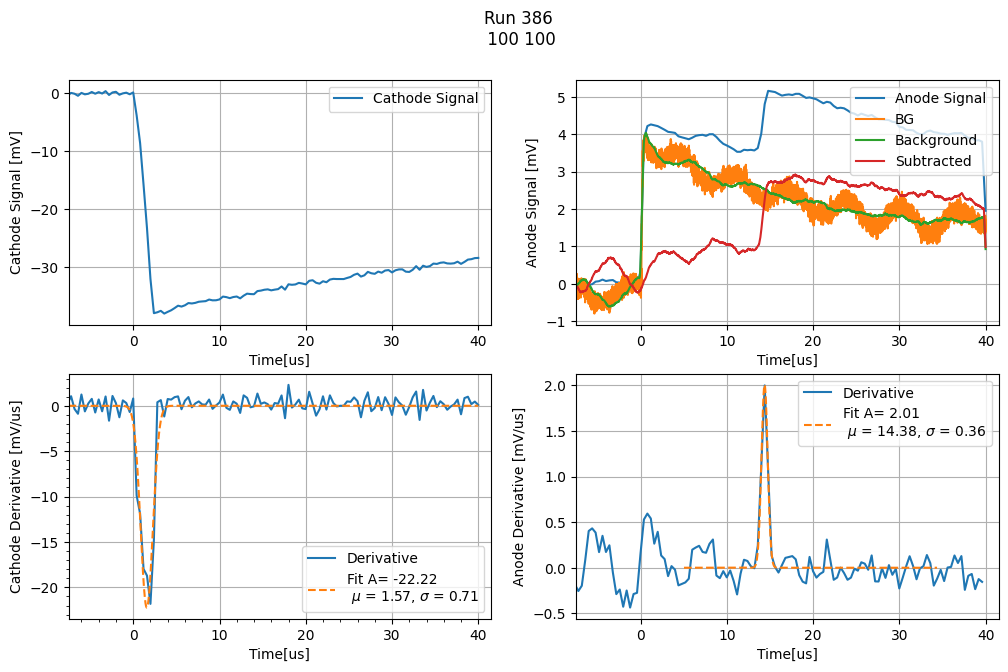

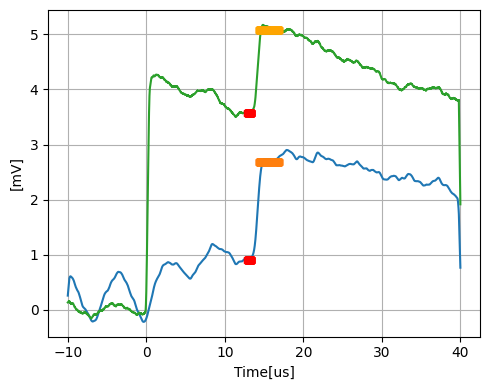

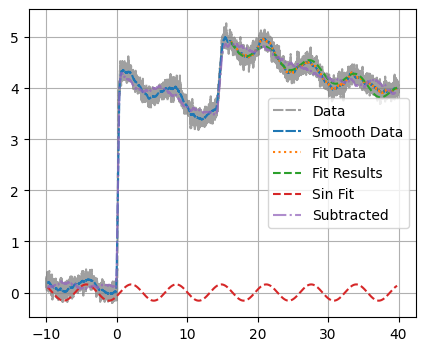

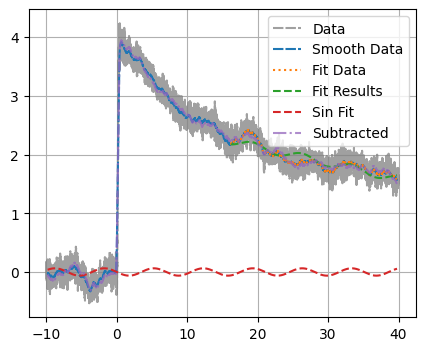

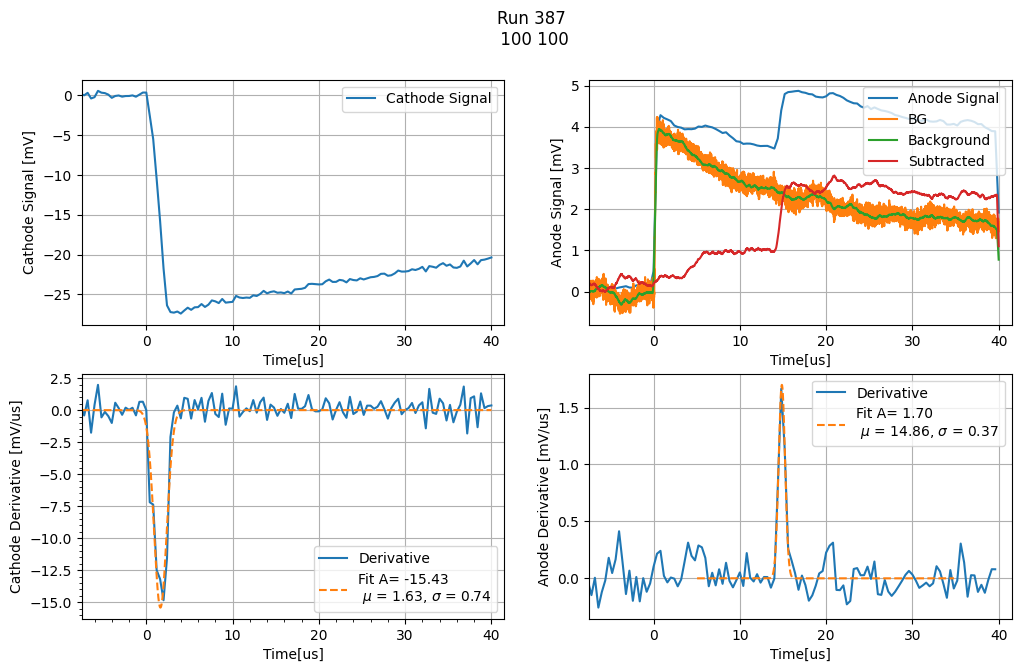

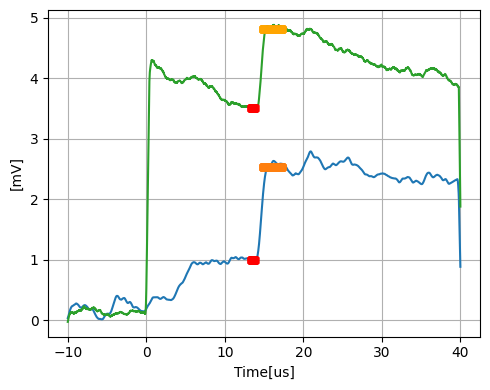

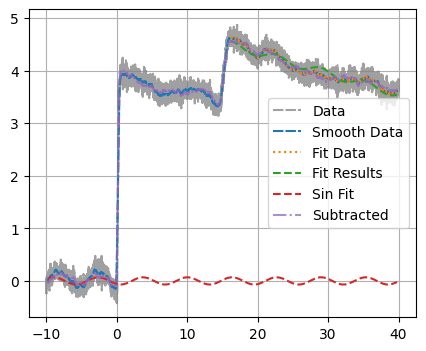

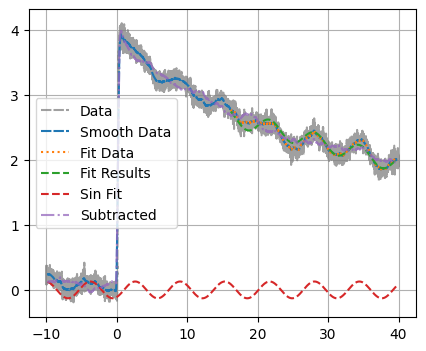

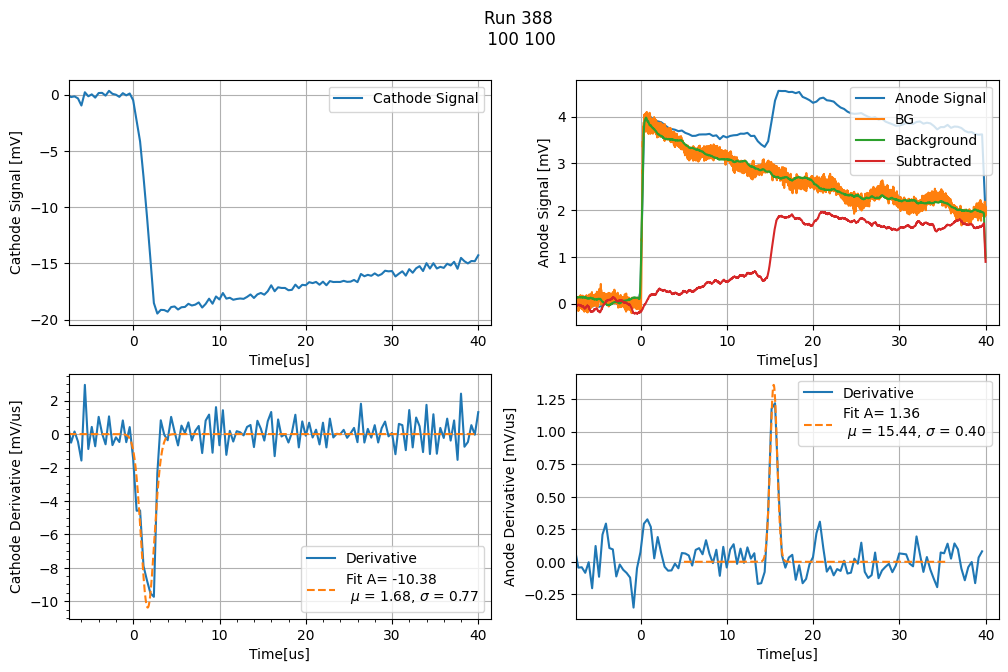

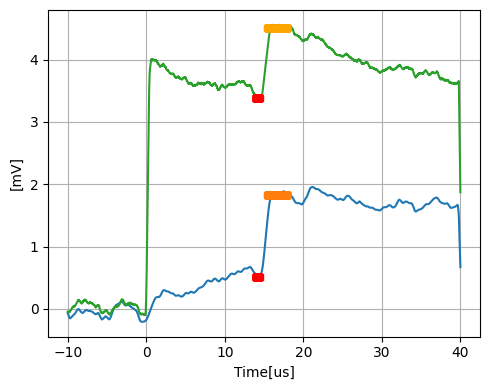

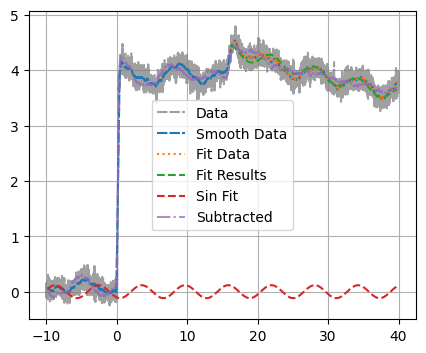

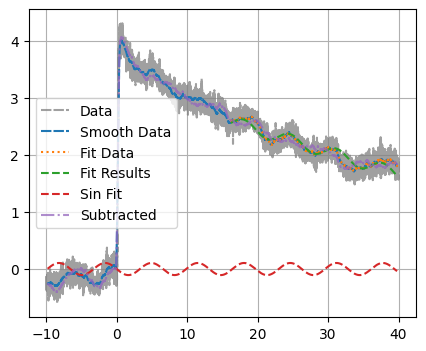

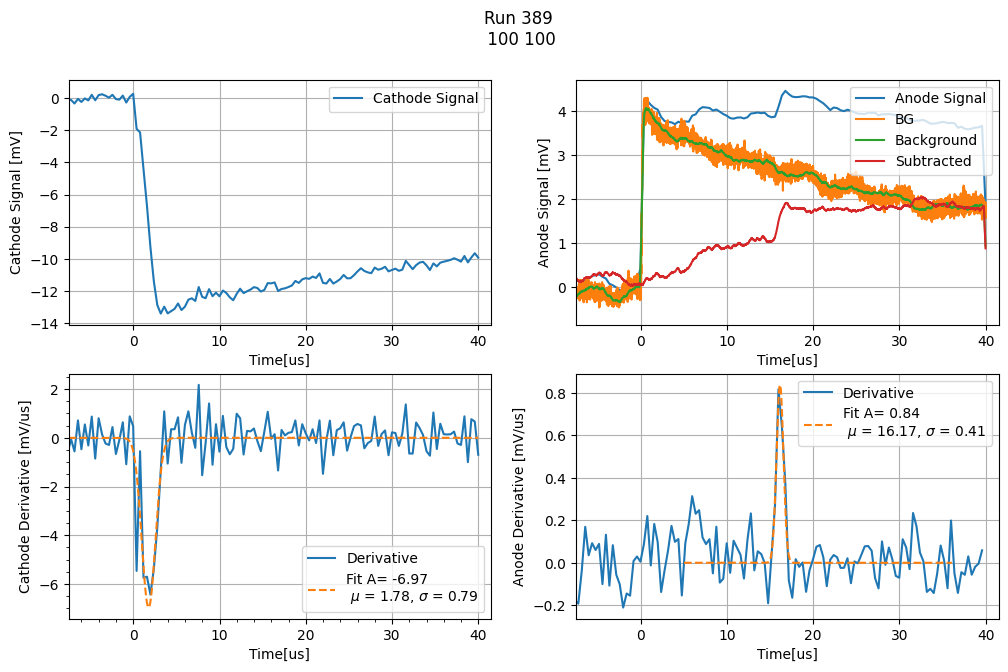

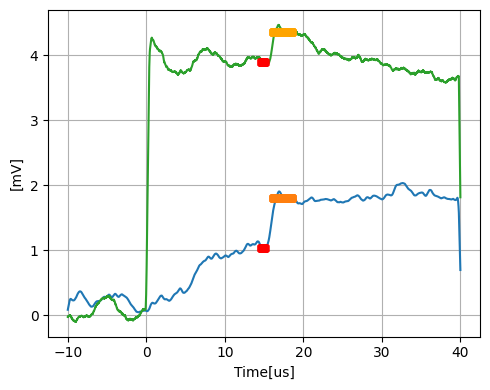

In [667]:
Nov11_DSweep_v1= AnalyzeRun([385,386,387,388,389],[100],[100],debug=1)
#,386,387,388,389

Run  194   BG-  221
Stepsize 100 , DiffSize 100
Time step size:  0.004
Mod step 100, res mod 1.0000, Zero time index 2511, Zero time 0.0370
starting sin removal
starting sin removal for bg
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03700005 	 2.037

modifed diffsize  100
fit start 3761 5.03699991
fit stop 12501 39.99699892
sec fit 13588 27.16899929
Anode p0  [6.8325 7.169  0.338 ]
Good fit, attempts 1
Sigma  0.2862504558312918
amp  6.8398019902789935
mu  7.168684079823686
anode strength, with/w/o 4.8253527442183275 2.887915872408958
cathode p0 [-261.1433    0.849     1.008 ]
Run  195   BG-  222
Stepsize 100 , DiffSize 100
Time step size:  0.004
Mod step 100, res mod 1.0000, Zero time index 2511, Zero time 0.0384
starting sin removal
starting sin removal for bg
DF length  12503 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03840005 	 2.0384

modifed diffsize  100
fit start 3761 5.03839991
fit stop 12502 40.00239892
sec fit 13656 27.30639928
Anode p0  [6.1807 

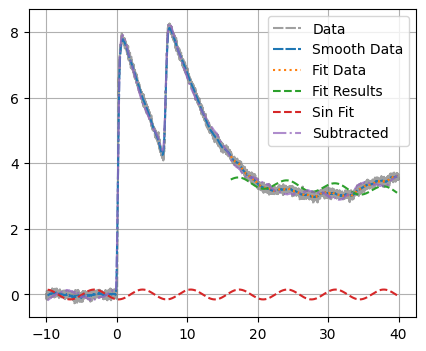

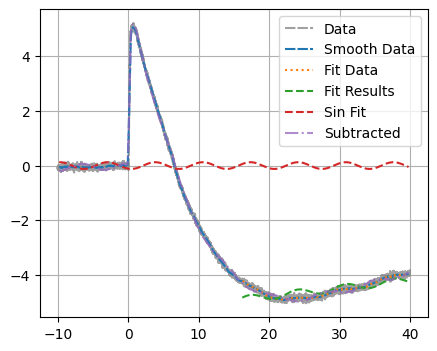

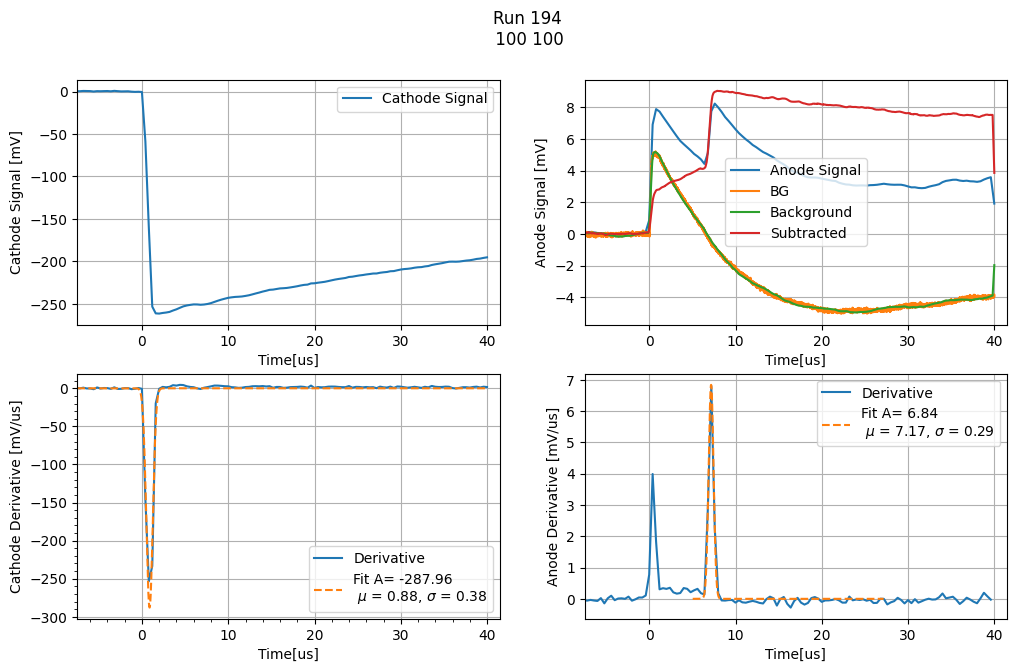

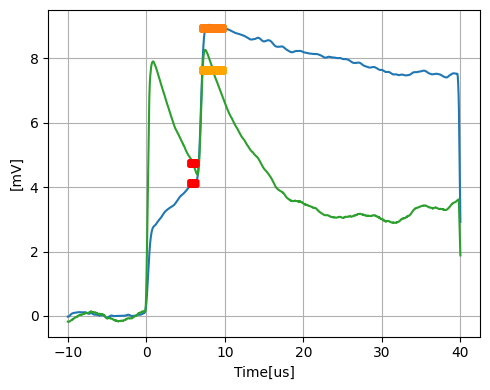

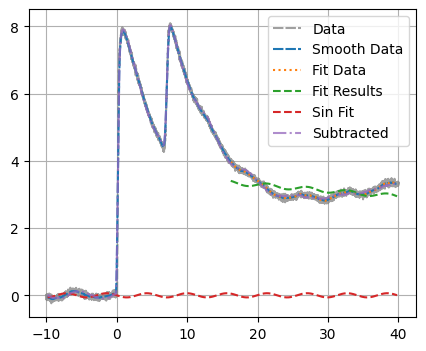

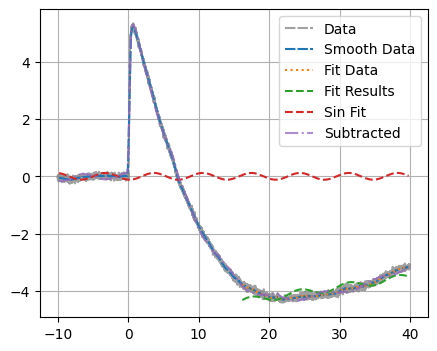

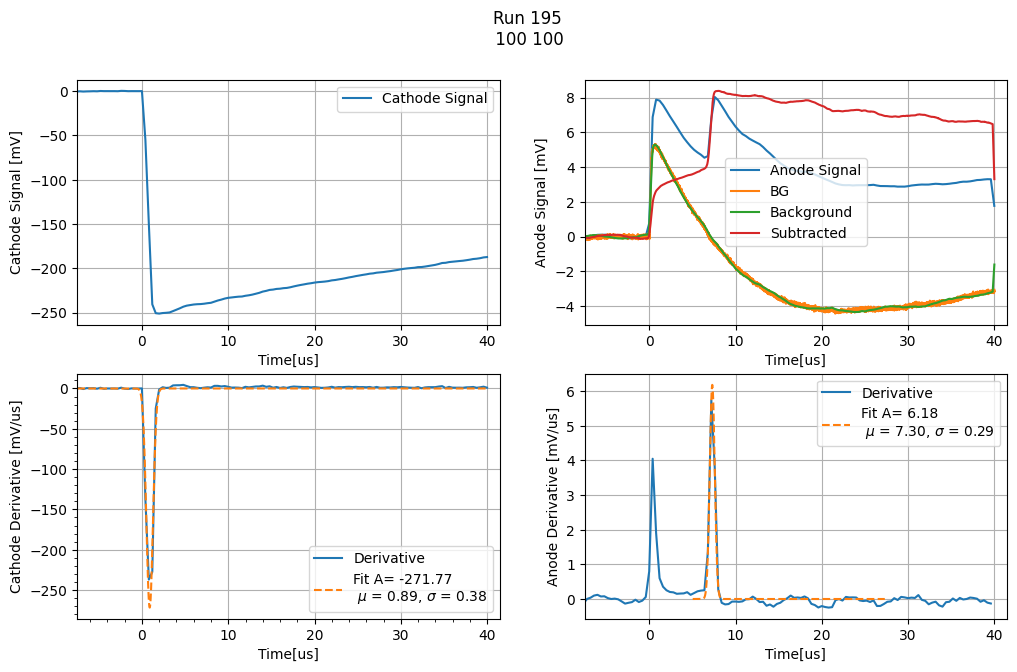

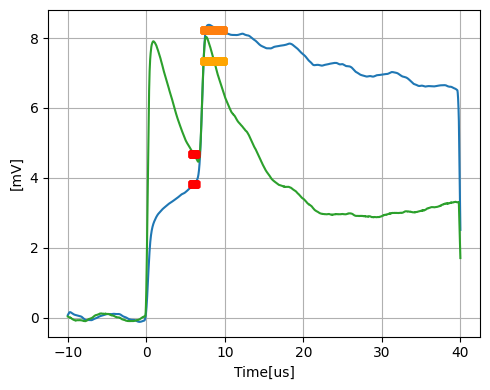

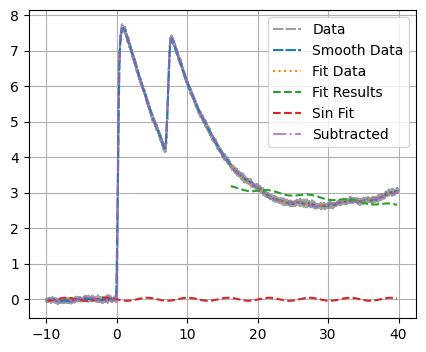

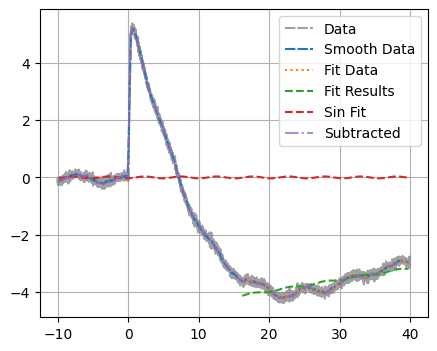

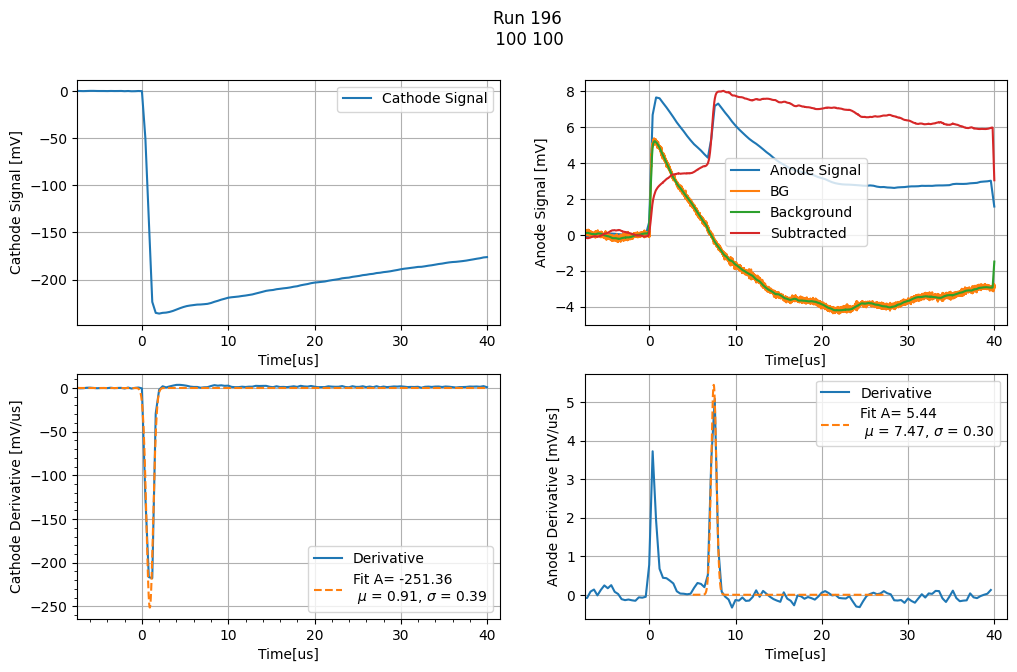

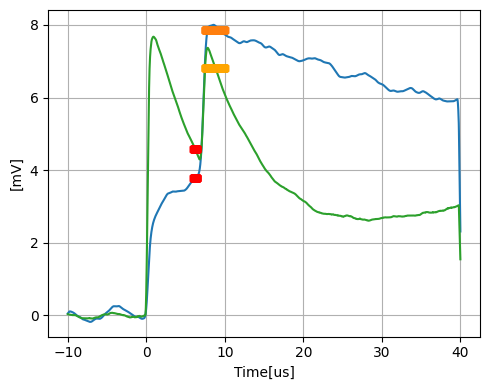

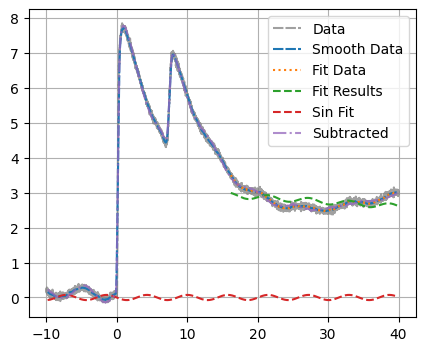

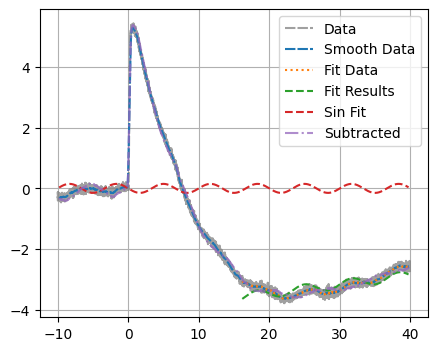

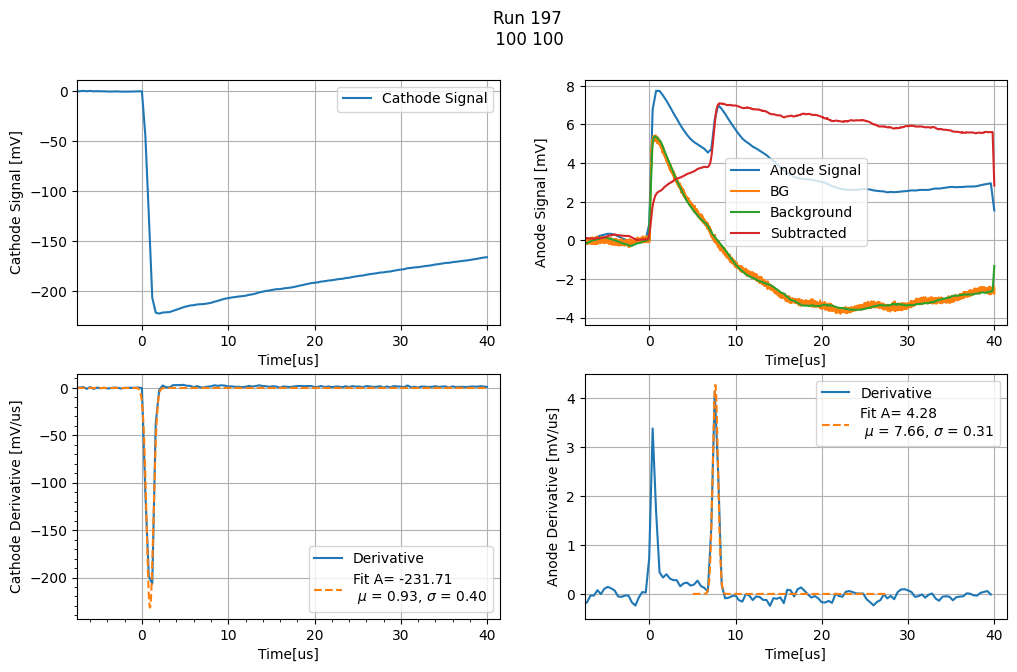

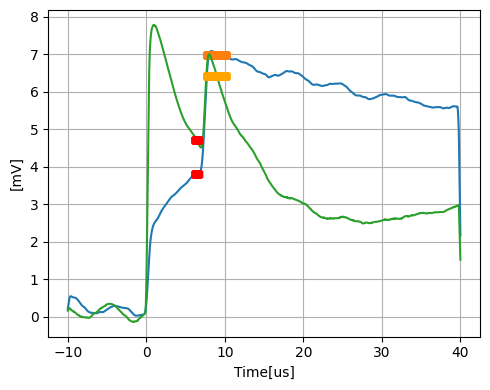

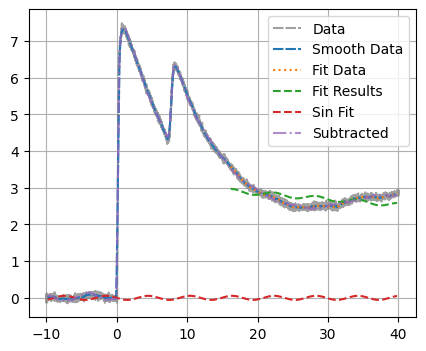

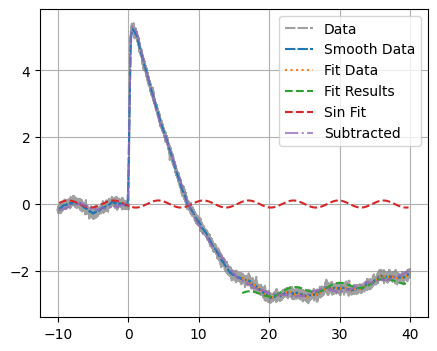

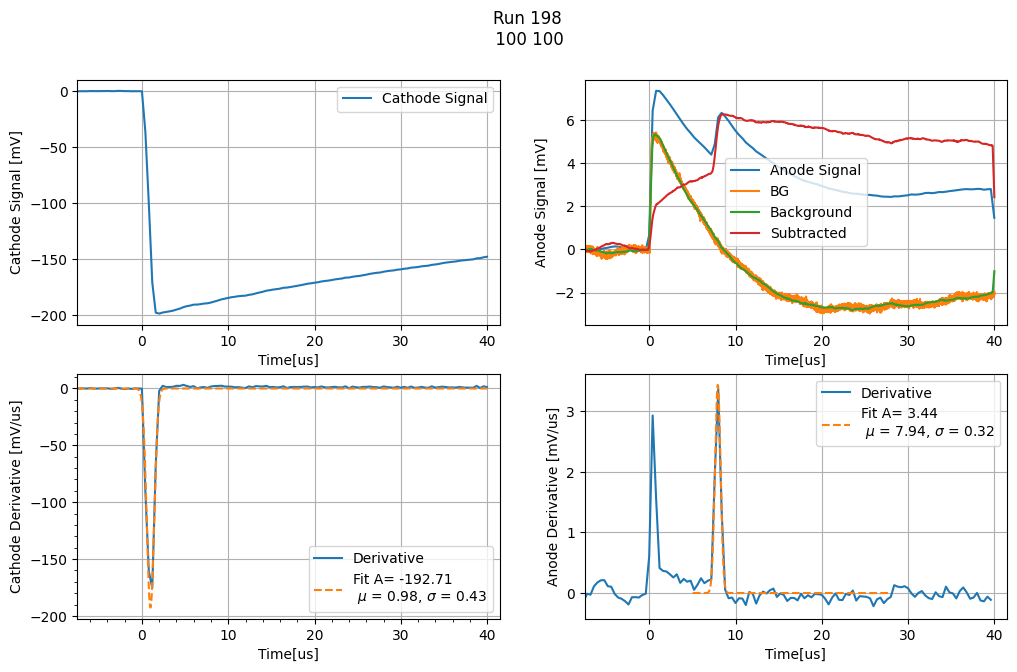

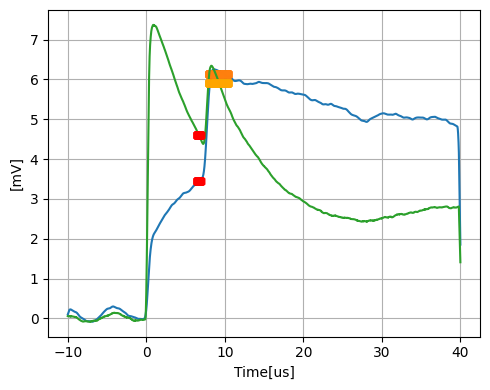

In [705]:

Oct11_DSweep_v2= AnalyzeRun([194,195,196,197,198],[100],[100],debug=10)


Run  176   BG-  208
Stepsize 100 , DiffSize 100
Time step size:  0.004
Mod step 100, res mod 1.0000, Zero time index 2511, Zero time 0.0360
starting sin removal
starting sin removal for bg
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03600005 	 2.036

modifed diffsize  100
fit start 3762 5.03999991
fit stop 12501 39.99599892
sec fit 14022 28.03599926
Anode p0  [7.7805 8.036  0.42  ]
Good fit, attempts 1
Sigma  0.3472238016944584
amp  7.873698552012102
mu  8.036835139530675
anode strength, with/w/o 6.65010352817081 5.7561977374882165
cathode p0 [-65.7347   1.676    1.372 ]
Run  177   BG-  209
Stepsize 100 , DiffSize 100
Time step size:  0.004
Mod step 100, res mod 1.0000, Zero time index 2511, Zero time 0.0380
starting sin removal
starting sin removal for bg
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
DF length  12503 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03800005 	 2.038

modifed diffsize  100
fit start 3761 5

C:\Users\jasonbane\AppData\Local\Temp\ipykernel_18340\2058802348.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2,bx=plt.subplots(figsize=(5,4))


cathode p0 [-27.2592   1.864    0.032 ]
Run  182   BG-  214
Stepsize 100 , DiffSize 100
Time step size:  0.004
Mod step 100, res mod 1.0000, Zero time index 2511, Zero time 0.0360
starting sin removal
starting sin removal for bg
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
DF length  12503 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03600005 	 2.036

modifed diffsize  100
fit start 3762 5.03999991
fit stop 12502 39.99999892
sec fit 14468 28.92799924
Anode p0  [3.0938e+00 8.9280e+00 2.0000e-03]
old Results
Sigma  0.003999999999999559
amp  4.3745767625549865
(guess-A)/A  0.4139814573524914
mu  8.928001307864212
new Fit  1
last index 7734  Time  20.92799946
first index 3762 time 5.03999991
Fitting limits 5.03999991 20.92799946
old Results
Sigma  0.003999999999999559
amp  4.3745767625549865
(guess-A)/A  0.4139814573524914
mu  8.928001307864212
new Fit  2
last index 7234  Time  18.92799952
first index 3762 time 5.03999991
Fitting limits 5.0399

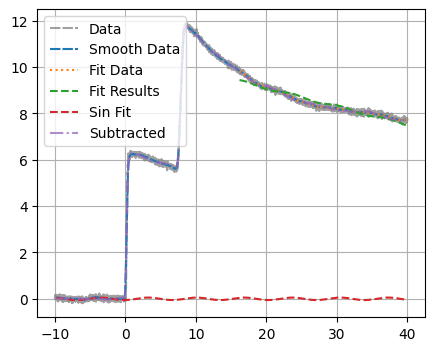

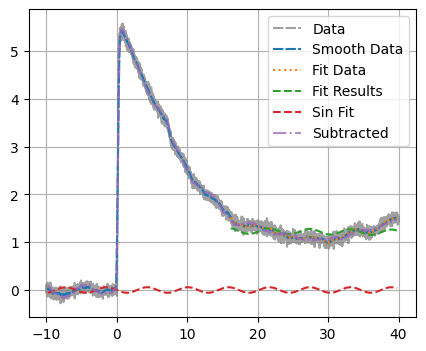

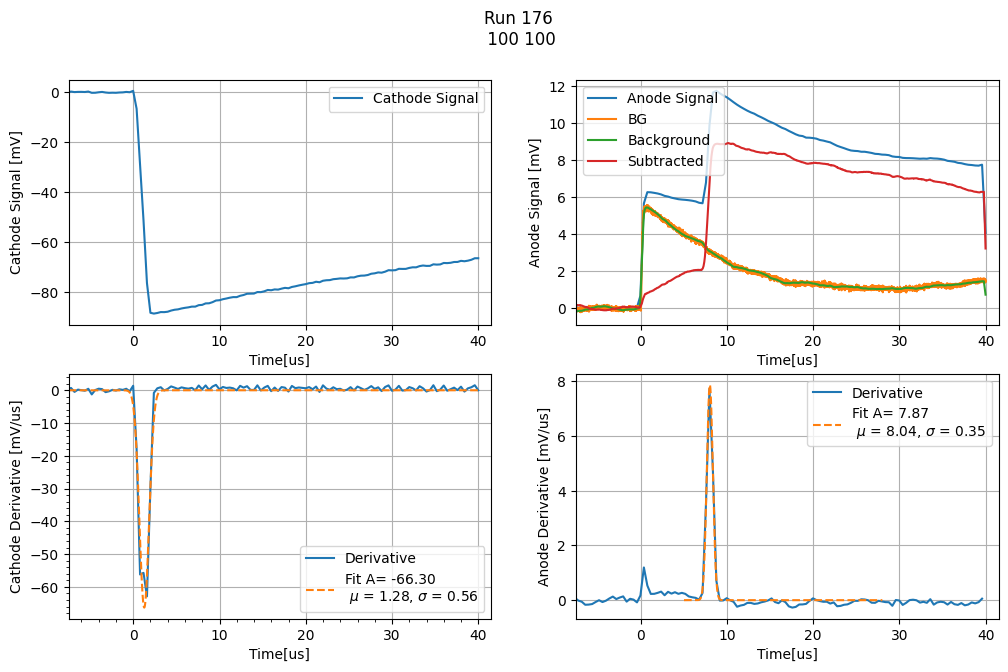

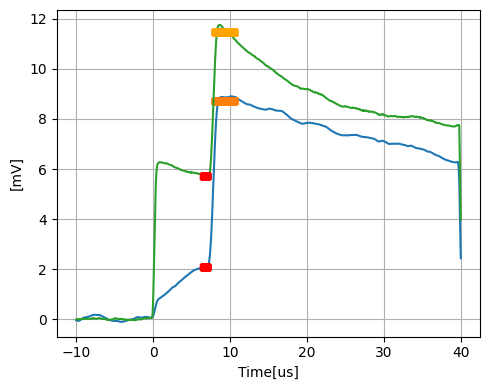

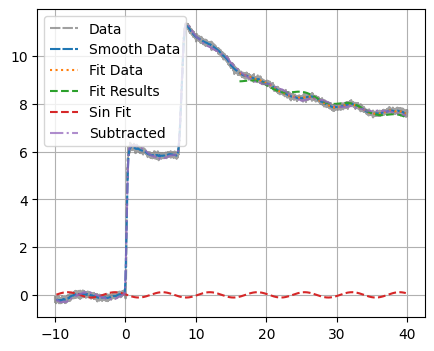

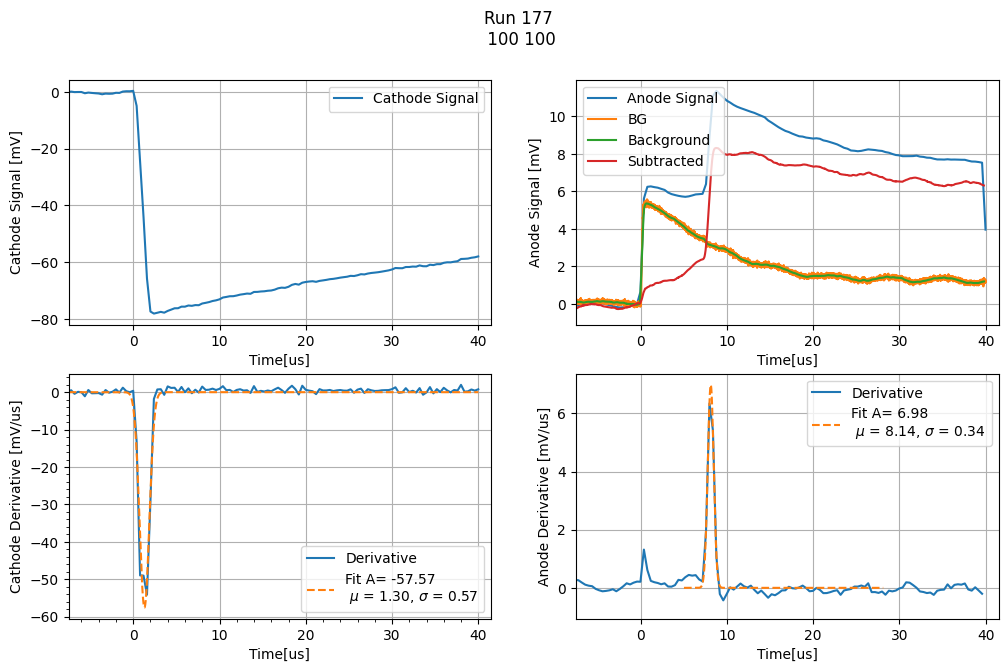

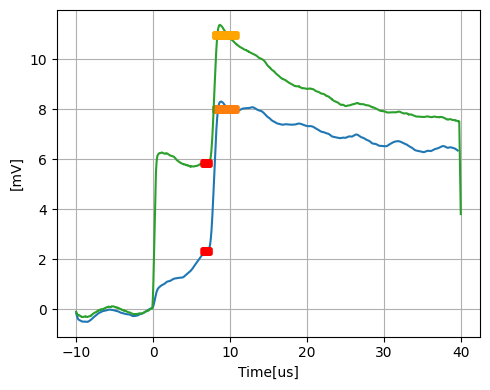

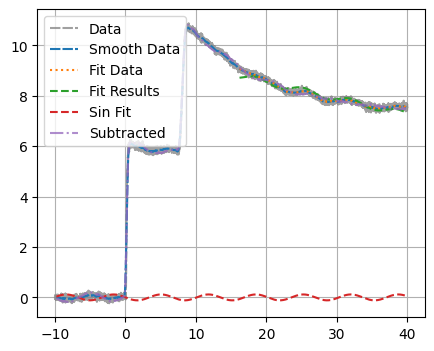

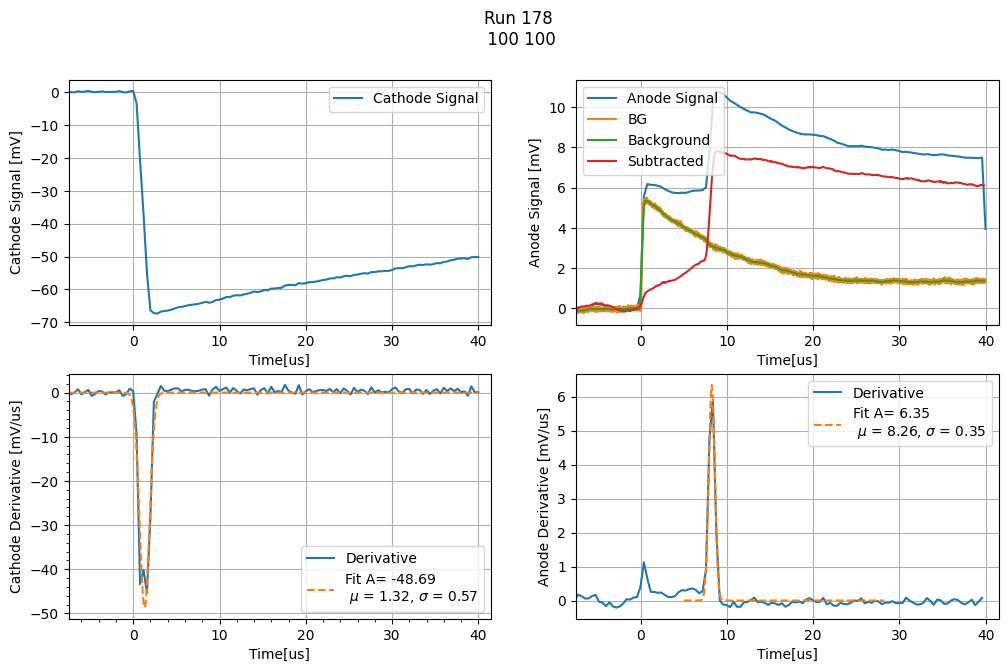

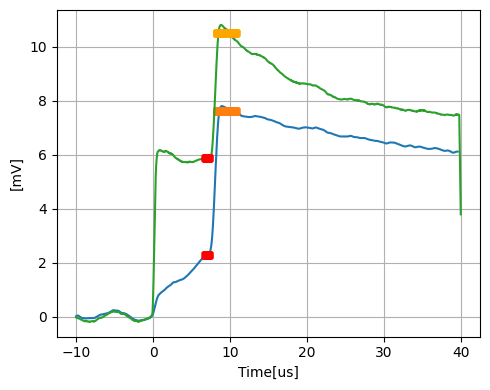

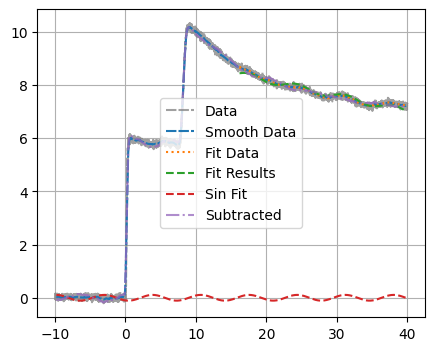

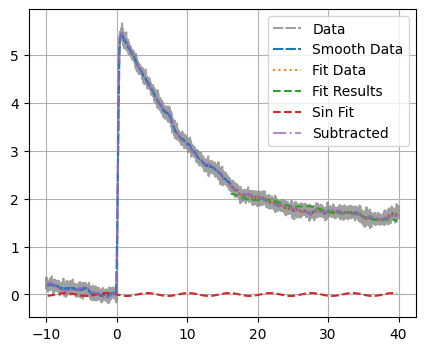

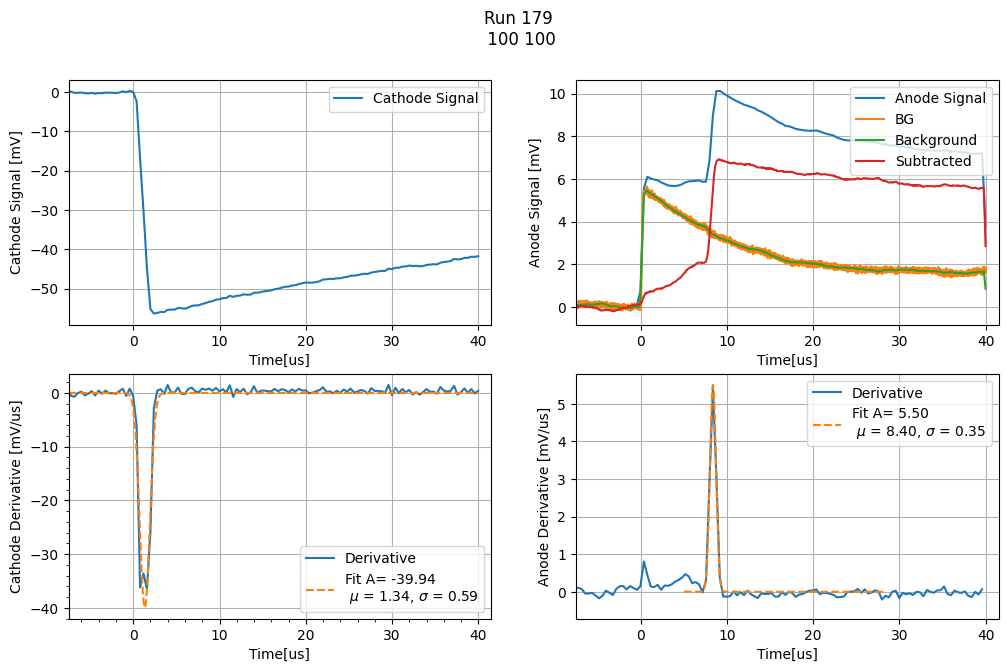

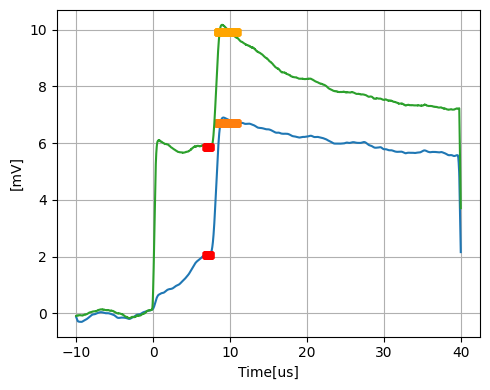

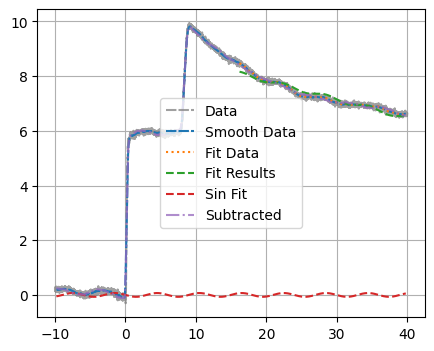

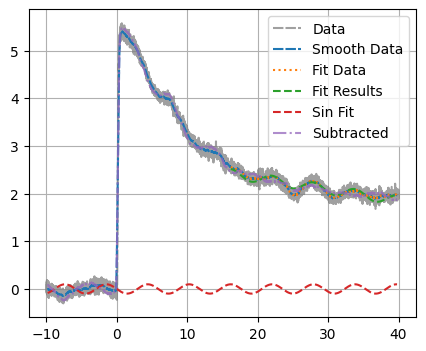

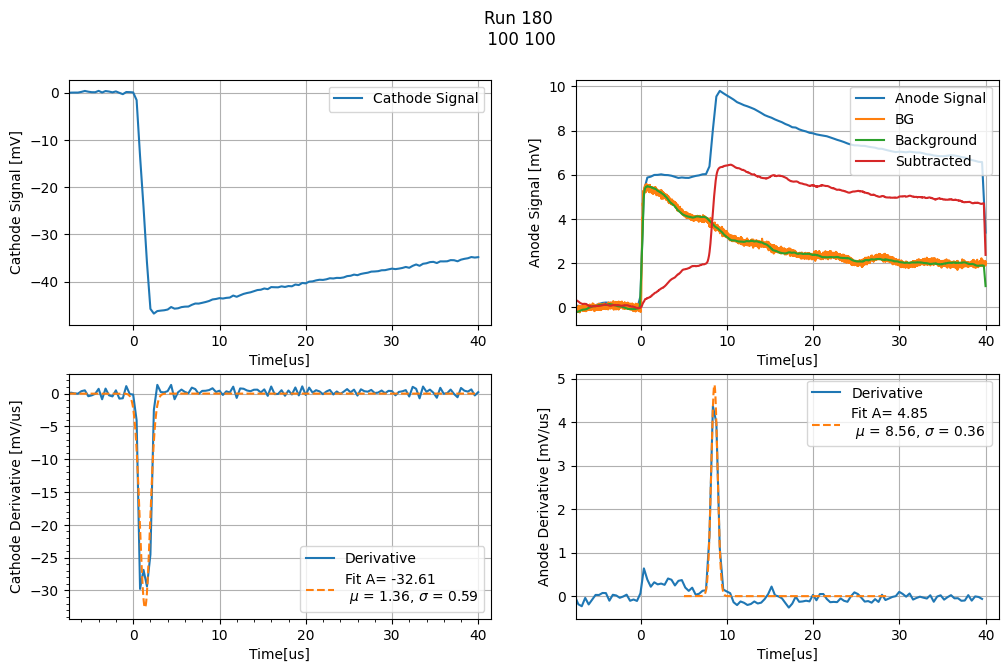

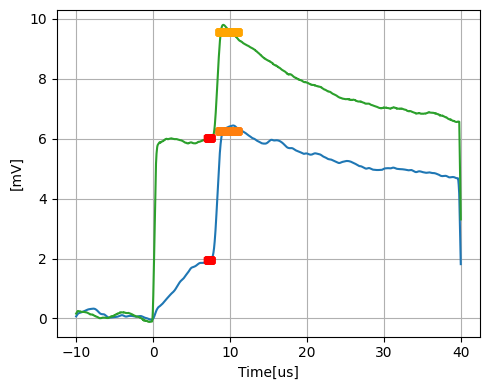

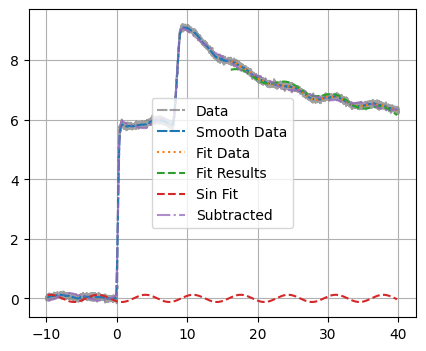

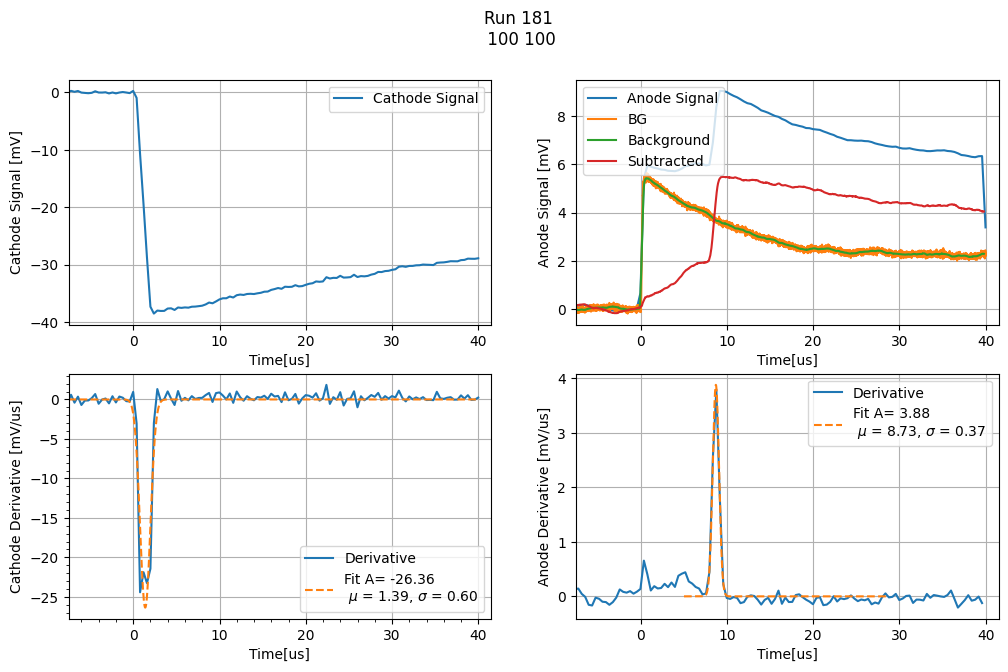

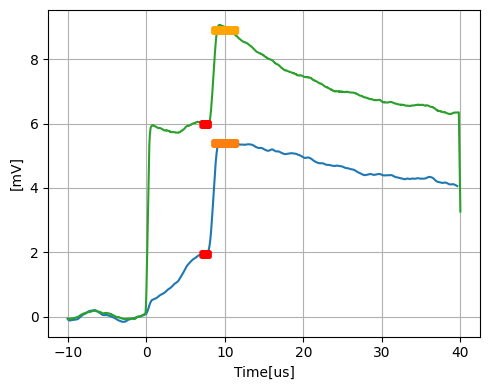

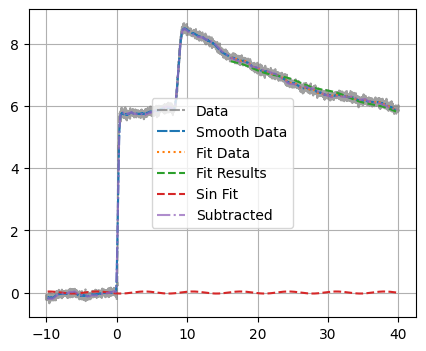

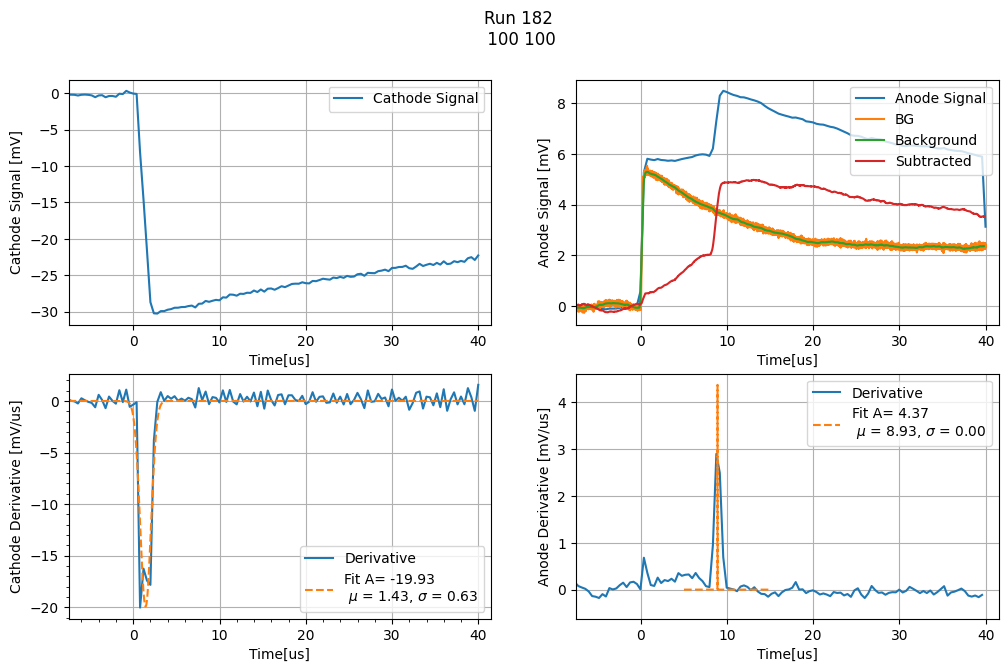

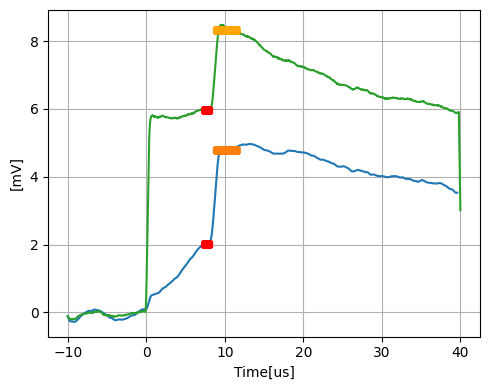

In [689]:

Oct11_DSweep_v1= AnalyzeRun([176,177,178,179,180,181,182],[100],[100],debug=10)
#AnalyzeRun([177],[100],[100],debug=10)

Run  388   BG-  391
Stepsize 100 , DiffSize 100
Time step size:  0.004
Mod step 100, res mod 1.0000, Zero time index 2511, Zero time 0.0373
starting sin removal
False False False
starting sin removal for bg
False False False
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03733339 	 2.03733333

modifed diffsize  100
fit start 3761 5.03733324
fit stop 12501 39.99733226
sec fit 17714 35.42133239
Anode p0  [ 1.3116 15.4213  0.51  ]
Good fit, attempts 1
Sigma  0.40317556547033195
amp  1.3597537419317423
mu  15.436266735545173
anode strength, with/w/o 1.3034401286461732 1.1332867412044805
cathode p0 [-12.5259   0.5773   2.364 ]


[{'Run': 388,
  'Anode P0': [1.3116468995964958, 15.42133295, 0.5099999899999998],
  'Anode Delay Time': 15.436266735545173,
  'Anode Delay Sigma': 0.40317556547033195,
  'Anode Amp': 1.3034401286461732,
  'Anode Amp notsub': 1.1332867412044805,
  'Cathode P0': [-12.525850313146272, 0.57733337, 2.36399993],
  'fit stepsize': 100,
  'fit diffsize': 100,
  'Cathode Delay Time': 1.6764588620177028,
  'Cathode Delay Sigma': 0.7715832649614583,
  'Cathode Amp': -10.381674116532222,
  'Cathode Wave Amp': 19.79601,
  'Drift Field': 401.7491392285555,
  'Extraction Field': 399.6277440192697,
  'pressure': 25.9,
  'Temp': 173.4,
  'Laser Current': 28.0,
  'Laser Freq.': 500.0,
  'Cathode V.': 913.0,
  'Drift Length': 20.90857}]

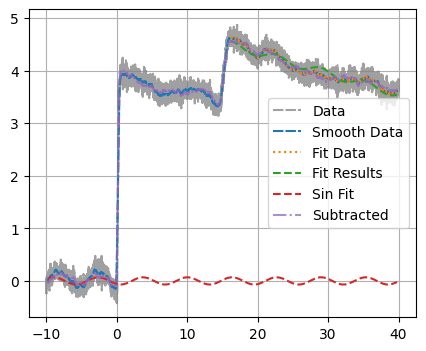

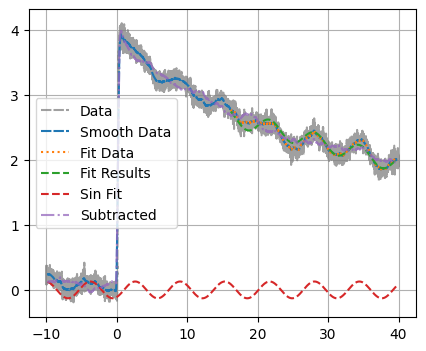

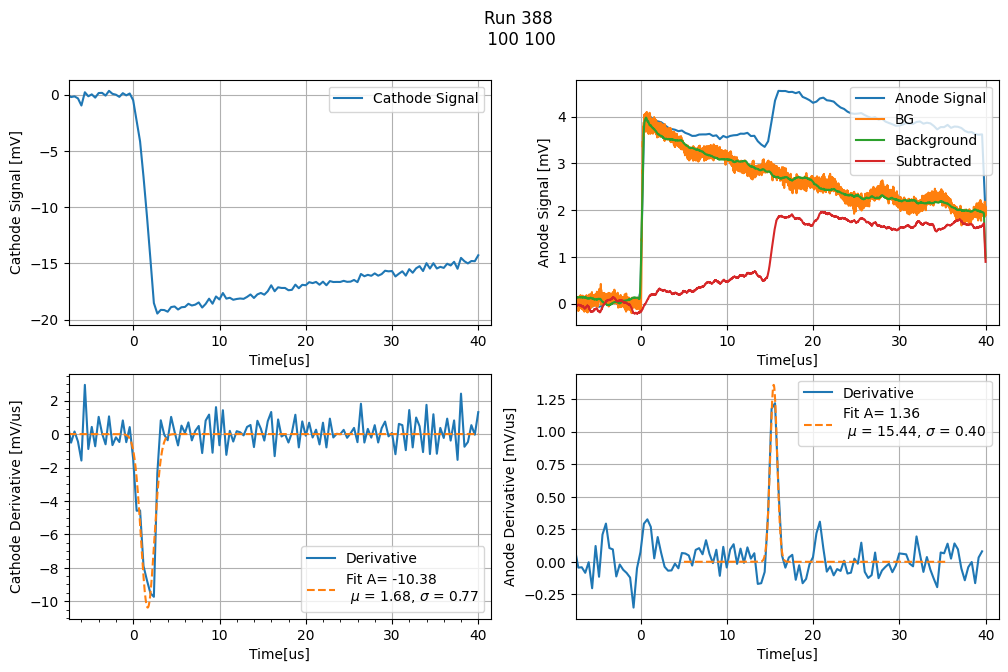

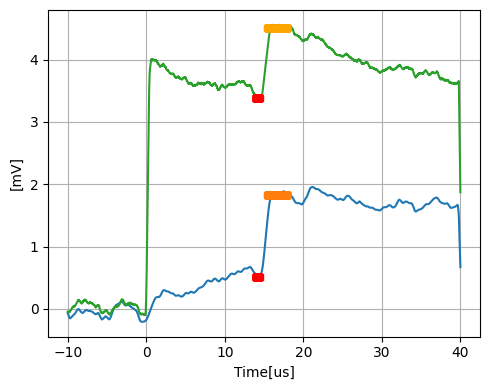

In [665]:
AnalyzeRun([388],[100],[100],debug=10)

Start  20 5000  stop  50 12500
Fit P0 [1.6280159000000003, 0.15, 0.1, -0.1, 2]
Bounds ([0, 0.001, -3.141592653589793, -1, -10], [1.6280159000000003, 1.5, 3.141592653589793, 1, 50])
Parameters [ 0.08039373  0.16089307  0.58945921 -0.05766507  4.59441509]
Covariance [[ 2.30165456e-06  4.61565108e-09  5.27227471e-08 -1.80157753e-08
   3.80397408e-07]
 [ 4.61565108e-09  1.26995936e-07 -2.00866929e-05 -5.64403321e-09
   1.74100028e-07]
 [ 5.27227471e-08 -2.00866929e-05  3.53560835e-03  1.08819305e-06
  -3.34248956e-05]
 [-1.80157753e-08 -5.64403321e-09  1.08819305e-06  1.61392017e-08
  -4.04840682e-07]
 [ 3.80397408e-07  1.74100028e-07 -3.34248956e-05 -4.04840682e-07
   1.13105013e-05]]


(array([ 0.08039373,  0.16089307,  0.58945921, -0.05766507,  4.59441509]),
 array([[ 2.30165456e-06,  4.61565108e-09,  5.27227471e-08,
         -1.80157753e-08,  3.80397408e-07],
        [ 4.61565108e-09,  1.26995936e-07, -2.00866929e-05,
         -5.64403321e-09,  1.74100028e-07],
        [ 5.27227471e-08, -2.00866929e-05,  3.53560835e-03,
          1.08819305e-06, -3.34248956e-05],
        [-1.80157753e-08, -5.64403321e-09,  1.08819305e-06,
          1.61392017e-08, -4.04840682e-07],
        [ 3.80397408e-07,  1.74100028e-07, -3.34248956e-05,
         -4.04840682e-07,  1.13105013e-05]]))

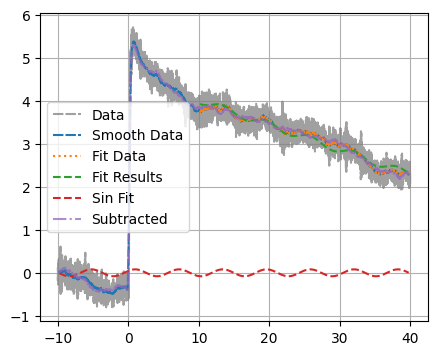

In [635]:
DF=GetWaveForm(381)
GetSinBG(DF["Time"],DF["Avg Anode"]-np.average(DF["Avg Anode"][:500]),20,50)

In [11]:
Nov01_DSweep_334

NameError: name 'Nov01_DSweep_334' is not defined

In [671]:
Nov01_Dsweep_DF_v3=pd.DataFrame.from_dict(Nov01_DSweep_v3)
Nov01_Dsweep_DF_V3=DV_ana(Nov01_Dsweep_DF_v3)



In [379]:
Nov01_Dsweep_DF_v3[:5]

Run                                           Anode P0  Anode Delay Time  \
0  334     [0.9054720733737701, 16.47799959, 13.18799963]         16.422526   
1  333  [1.1714638029814843, 15.57599961, 6.7079998100...         15.500513   
2  332  [1.2440433908510868, 14.97359963, 4.6299998700...         14.950312   
3  331  [1.3704209387605255, 14.55933298, 4.3219998749...         14.565369   
4  330  [2.1305098837627505, 14.32533298, 0.0019999999...         14.324360   

   Anode Delay Sigma  Anode Amp  Anode Amp notsub  \
0           0.470479   0.682499          0.608499   
1           0.498701   0.943991          0.681984   
2           0.314096   0.967822          0.567064   
3           0.328506   1.011314          0.770093   
4           0.004000   1.692601          1.233441   

                                          Cathode P0  fit stepsize  \
0   [-14.741425368535587, 1.966, 1.8199999500000001]           100   
1    [-21.02782552569566, 1.788, 1.6399999500000002]           100   
2   [-32.74940081873506, 1.7896, 1.5879999599999999]           100   
3  [-45.345951133648846, 1.75933334, 1.5839999599...           100   
4       [-57.29905143247634, 1.55333334, 1.51599996]           100   

   fit diffsize  Cathode Delay Time  ...  Extraction Field  pressure   Temp  \
0           100            1.448356  ...        301.089396      25.7  173.5   
1           100            1.387207  ...        400.722615      25.7  173.5   
2           100            1.341664  ...        500.355833      25.7  173.5   
3           100            1.300628  ...        596.704440      25.7  173.5   
4           100            1.255983  ...        699.622270      25.7  173.5   

   Laser Current  Laser Freq.  Cathode V.  Drift Length  Drift Vel  \
0           28.0        500.0       685.0      20.90857   1.396309   
1           28.0        500.0       913.2      20.90857   1.481479   
2           28.0        500.0      1141.4      20.90857   1.536418   
3           28.0        500.0      1369.0      20.90857   1.576252   
4           28.0        500.0      1597.8      20.90857   1.599936   

   Avg Drift Vel  Avg Drift Vel STD  
0       1.396309                NaN  
1       1.481479                NaN  
2       1.536418                NaN  
3       1.576252                NaN  
4       1.599936                NaN  

[5 rows x 24 columns]

In [368]:
Nov01_Dsweep_DF[["Run","Drift Vel","Anode Amp", "Cathode Amp","Anode Delay Time","Cathode Delay Time"]][:3]

NameError: name 'Nov01_Dsweep_DF' is not defined

In [672]:
anode_preamp_gain=0.656
catho_preamp_gain=0.708
Nov01_Dsweep_DF_v3=pd.DataFrame.from_dict(Nov01_DSweep_v3)
Nov01_Dsweep_DF_V3=DV_ana(Nov01_Dsweep_DF_v3)


DF_nov1=Nov01_Dsweep_DF_v3
Q_c=np.abs(DF_nov1["Cathode Wave Amp"]*catho_preamp_gain)
Q_a=np.abs(DF_nov1["Anode Amp"]  *anode_preamp_gain)
DF_nov1["Anode Q"]=Q_a
DF_nov1["Cathode Q"]=Q_c
DF_nov1["Drift Time"]=(DF_nov1["Anode Delay Time"]-DF_nov1["Cathode Delay Time"])
DF_nov1["LifeTime"] = (DF_nov1["Anode Delay Time"]-DF_nov1["Cathode Delay Time"]) / ( np.log(Q_c/Q_a))
print()


DF_nov1[["Run","Drift Vel","Anode Amp", "Cathode Amp","Drift Time","LifeTime","Anode Q","Cathode Q"]][-3:]

Run  Drift Vel  Anode Amp  Cathode Amp  Drift Time  LifeTime   Anode Q  \
2  332   1.566036   0.993409   -32.382446   13.351271  3.399183  0.651676   
3  331   1.594618   0.948299   -45.573494   13.111959  3.059513  0.622084   
4  330   1.631055   1.729562   -57.695611   12.819050  3.289300  1.134593   

   Cathode Q  
2  33.101591  
3  45.193580  
4  55.894773

In [ ]:
anode_preamp_gain=0.656
catho_preamp_gain=0.708
Nov11_Dsweep_DF_v1=pd.DataFrame.from_dict(Nov11_DSweep_v1)
Nov11_Dsweep_DF_V1=DV_ana(Nov11_Dsweep_DF_v1)


DF_nov11=Nov11_Dsweep_DF_v1
Q_c=np.abs(DF_nov11["Cathode Wave Amp"]*catho_preamp_gain)
Q_a=np.abs(DF_nov11["Anode Amp"]  *anode_preamp_gain)
DF_nov11["Anode Q"]=Q_a
DF_nov11["Cathode Q"]=Q_c
DF_nov11["Drift Time"]=(DF_nov11["Anode Delay Time"]-DF_nov11["Cathode Delay Time"])
DF_nov11["LifeTime"] = (DF_nov11["Anode Delay Time"]-DF_nov11["Cathode Delay Time"]) / ( np.log(Q_c/Q_a))
print()


DF_nov11[["Run","Drift Vel","Anode Amp", "Cathode Amp","Drift Time","LifeTime","Anode Q","Cathode Q"]][-3:]

Run  Drift Vel  Anode Amp  Cathode Amp  Drift Time  LifeTime   Anode Q  \
2  387   1.579961   1.529981   -15.426156   13.233601  4.440624  1.003667   
3  388   1.519539   1.303440   -10.381674   13.759808  4.919916  0.855057   
4  389   1.453213   0.761408    -6.965486   14.387823  4.829344  0.499484   

   Cathode Q  
2  19.762425  
3  14.015575  
4   9.826370

In [690]:
anode_preamp_gain=0.656
catho_preamp_gain=0.708
Oct11_Dsweep_DF_v1=pd.DataFrame.from_dict(Oct11_DSweep_v1)
Oct11_Dsweep_DF_V1=DV_ana(Oct11_Dsweep_DF_v1)


DF_Oct11=Oct11_Dsweep_DF_v1
Q_c=np.abs(DF_Oct11["Cathode Wave Amp"]*catho_preamp_gain)
Q_a=np.abs(DF_Oct11["Anode Amp"]  *anode_preamp_gain)
DF_Oct11["Anode Q"]=Q_a
DF_Oct11["Cathode Q"]=Q_c
DF_Oct11["Drift Time"]=(DF_Oct11["Anode Delay Time"]-DF_Oct11["Cathode Delay Time"])
DF_Oct11["LifeTime"] = (DF_Oct11["Anode Delay Time"]-DF_Oct11["Cathode Delay Time"]) / ( np.log(Q_c/Q_a))
print()


DF_Oct11[["Run","Drift Vel","Anode Amp", "Cathode Amp","Drift Time","LifeTime","Anode Q","Cathode Q"]][-3:]

Run  Drift Vel  Anode Amp  Cathode Amp  Drift Time  LifeTime   Anode Q  \
4  180   1.275678   4.334857   -32.611835    7.200092  2.923124  2.843666   
5  181   1.250594   3.444074   -26.358312    7.344511  2.939265  2.259312   
6  182   1.225557   2.777332   -19.925029    7.494550  3.027237  1.821930   

   Cathode Q  
4  33.389570  
5  27.489873  
6  21.662938

In [707]:
anode_preamp_gain=0.656
catho_preamp_gain=0.708
Oct11_Dsweep_DF_v2=pd.DataFrame.from_dict(Oct11_DSweep_v2)
Oct11_Dsweep_DF_v2=DV_ana(Oct11_Dsweep_DF_v2)


DF_Oct11_v2=Oct11_Dsweep_DF_v2
Q_c=np.abs(DF_Oct11_v2["Cathode Wave Amp"]*catho_preamp_gain)
Q_a=np.abs(DF_Oct11_v2["Anode Amp"]  *anode_preamp_gain)
DF_Oct11_v2["Anode Q"]=Q_a
DF_Oct11_v2["Cathode Q"]=Q_c
DF_Oct11_v2["Drift Time"]=(DF_Oct11_v2["Anode Delay Time"]-DF_Oct11_v2["Cathode Delay Time"])
DF_Oct11_v2["LifeTime"] = (DF_Oct11_v2["Anode Delay Time"]-DF_Oct11_v2["Cathode Delay Time"]) / ( np.log(Q_c/Q_a))
print()


DF_Oct11_v2[["Run","Drift Vel","Anode Amp", "Cathode Amp","Drift Time","LifeTime","Anode Q","Cathode Q"]][-3:]

Run  Drift Vel  Anode Amp  Cathode Amp  Drift Time  LifeTime   Anode Q  \
2  196   1.398557   4.072800  -251.355546    6.567482  1.587329  2.671757   
3  197   1.363789   3.187740  -231.711264    6.734914  1.556962  2.091157   
4  198   1.319415   2.698464  -192.713619    6.961417  1.590519  1.770192   

    Cathode Q  
2  167.365083  
3  158.126469  
4  140.880113

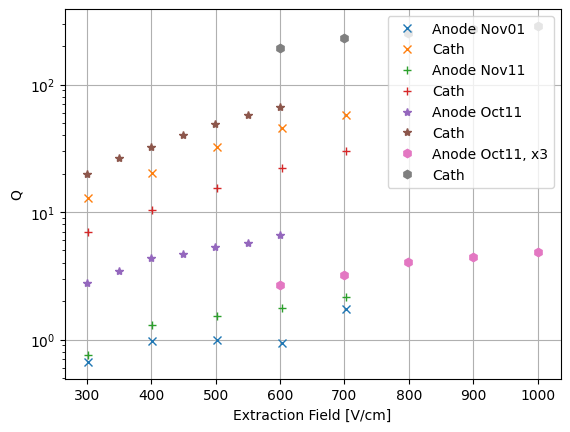

In [786]:
DF=DF_nov1
plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp"],fmt=" ",marker="x",label="Anode Nov01")
#plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp notsub"],fmt=" ",marker="x",label="Anode w/o backgroud subtraction")


plt.errorbar(x=DF["Drift Field"], y=abs(DF["Cathode Amp"]),fmt=" ",marker="x",label="Cath")

DF=DF_nov11
plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp"],fmt=" ",marker="+",label="Anode Nov11")
#plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp notsub"],fmt=" ",marker="x",label="Anode w/o backgroud subtraction")
plt.errorbar(x=DF["Drift Field"], y=abs(DF["Cathode Amp"]),fmt=" ",marker="+",label="Cath")

DF=DF_Oct11
plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp"],fmt=" ",marker="*",label="Anode Oct11")
#plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp notsub"],fmt=" ",marker="x",label="Anode w/o backgroud subtraction")
plt.errorbar(x=DF["Drift Field"], y=abs(DF["Cathode Amp"]),fmt=" ",marker="*",label="Cath")

DF=DF_Oct11_v2
plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp"],fmt=" ",marker="h",label="Anode Oct11, x3")
#plt.errorbar(x=DF["Drift Field"], y=DF["Anode Amp notsub"],fmt=" ",marker="x",label="Anode w/o backgroud subtraction")
plt.errorbar(x=DF["Drift Field"], y=abs(DF["Cathode Amp"]),fmt=" ",marker="h",label="Cath")

#/max(DF["Cathode Q"])/max(DF["Anode Q"])
plt.ylabel("Q")
plt.xlabel("Extraction Field [V/cm]")
plt.legend()
plt.yscale("log")
plt.grid()

Text(0, 0.5, 'ln(Cathode Q/ Anode Q)')

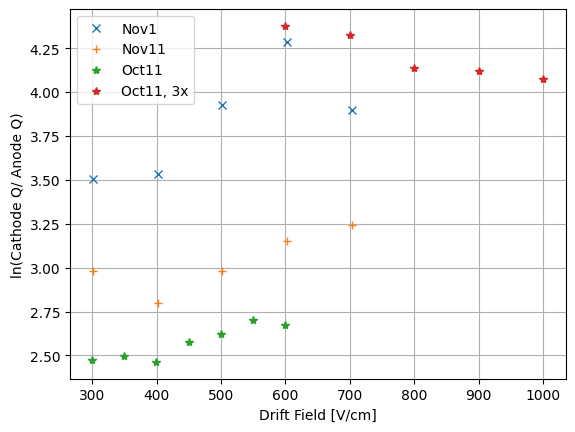

In [709]:
DF=DF_nov1
plt.errorbar(x=DF["Drift Field"],y=np.log(DF["Cathode Q"]/DF["Anode Q"]), fmt=" ",marker="x", label="Nov1")
DF=DF_nov11
plt.errorbar(x=DF["Drift Field"],y=np.log(DF["Cathode Q"]/DF["Anode Q"]), fmt=" ",marker="+", label="Nov11")
DF=DF_Oct11
plt.errorbar(x=DF["Drift Field"],y=np.log(DF["Cathode Q"]/DF["Anode Q"]), fmt=" ",marker="*", label="Oct11")

DF=DF_Oct11_v2
plt.errorbar(x=DF["Drift Field"],y=np.log(DF["Cathode Q"]/DF["Anode Q"]), fmt=" ",marker="*", label="Oct11, 3x")


plt.grid()
plt.legend()
plt.xlabel("Drift Field [V/cm]")
plt.ylabel("ln(Cathode Q/ Anode Q)")

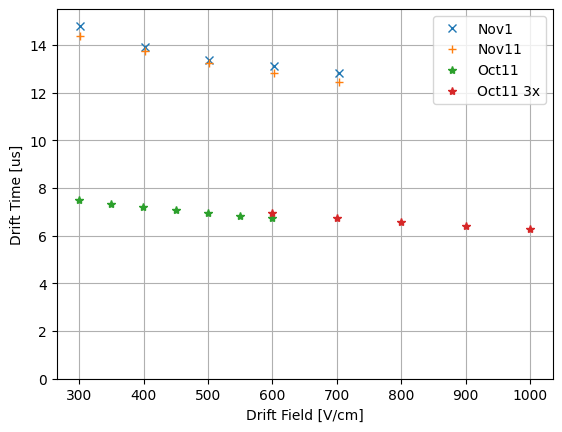

In [710]:
DF=DF_nov1
plt.errorbar(x=DF["Drift Field"],y=DF["Drift Time"], fmt=" ",marker="x", label="Nov1")

DF=DF_nov11
plt.errorbar(x=DF["Drift Field"],y=DF["Drift Time"], fmt=" ",marker="+", label="Nov11")

DF=DF_Oct11
plt.errorbar(x=DF["Drift Field"],y=DF["Drift Time"], fmt=" ",marker="*", label="Oct11")
DF=DF_Oct11_v2
plt.errorbar(x=DF["Drift Field"],y=DF["Drift Time"], fmt=" ",marker="*", label="Oct11 3x")


plt.grid()
plt.xlabel("Drift Field [V/cm]")
plt.ylabel("Drift Time [us]")
plt.ylim(0,15.5)
plt.legend()


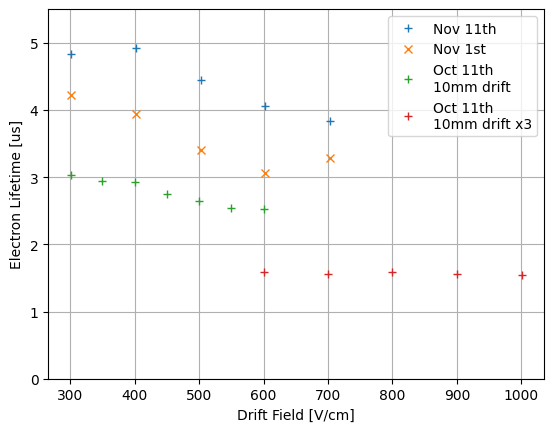

In [712]:
DF=DF_nov11
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],fmt=" ",marker="+",label="Nov 11th")

DF=DF_nov1
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],fmt=" ",marker="x",label="Nov 1st")

DF=DF_Oct11
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],fmt=" ",marker="+",label="Oct 11th\n10mm drift")

DF=DF_Oct11_v2
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],fmt=" ",marker="+",label="Oct 11th\n10mm drift x3")


#plt.errorbar(x=DF["Drift Field"],y=DF["Drift Time"]/np.log(abs(DF["Cathode Amp"]*0.708)/(DF["Anode Amp notsub"]*0.656)),fmt=" ",marker="x",label="Lifetime Nov. 1st w/o BG sub")

plt.ylabel("Electron Lifetime [us]")
plt.xlabel("Drift Field [V/cm]")
plt.ylim(0,5.5)
plt.legend()
plt.grid()

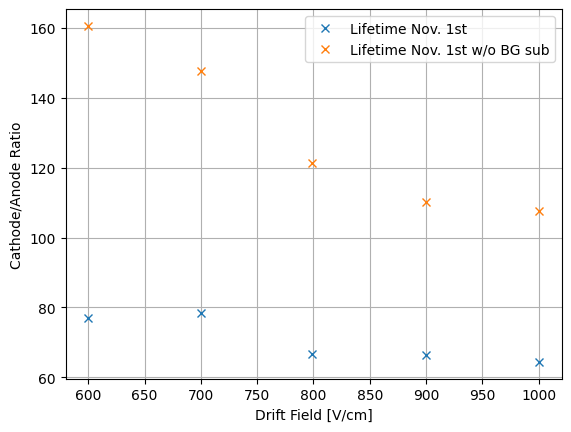

In [711]:
plt.errorbar(x=DF["Drift Field"],y=(abs(DF["Cathode Amp"]*0.708)/(DF["Anode Amp"]*0.656)),fmt=" ",marker="x",label="Lifetime Nov. 1st")
plt.errorbar(x=DF["Drift Field"],y=(abs(DF["Cathode Amp"]*0.708)/(DF["Anode Amp notsub"]*0.656)),fmt=" ",marker="x",label="Lifetime Nov. 1st w/o BG sub")

plt.ylabel("Cathode/Anode Ratio")
plt.xlabel("Drift Field [V/cm]")
plt.legend()
plt.grid()

norm  28.570762611275963
[0.5544615999999999, 0.15, 0.1, -0.1, 2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 0.182978    0.15744183 -2.31223773  0.01425342 -0.63717887]
[[1.83720295e-06 3.93144726e-08 6.12931251e-07 5.99351768e-08
  3.04488194e-09]
 [3.93144726e-08 1.69572358e-07 5.18964492e-06 5.22167553e-08
  3.22560357e-07]
 [6.12931251e-07 5.18964492e-06 2.10702749e-04 1.99213361e-06
  1.29747600e-05]
 [5.99351768e-08 5.22167553e-08 1.99213361e-06 1.20547323e-07
  6.22711883e-07]
 [3.04488194e-09 3.22560357e-07 1.29747600e-05 6.22711883e-07
  4.14231865e-06]]
[1.4344836, 0.15, 0.1, -0.1, 2]
[ 0.19396487  0.15507301 -2.27493172 -0.04483119  4.09278558]
[[ 1.58017945e-06  5.62992617e-09 -1.06812116e-06  2.48572692e-08
  -7.09734943e-07]
 [ 5.62992617e-09  2.74260711e-08 -4.81944361e-06  5.55198746e-09
  -1.52215989e-07]
 [-1.06812116e-06 -4.81944361e-06  8.91880933e-04 -9.59430809e-07
   2.68609280e-05]
 [ 2.48572692e-08  5.55198746e-09 -9.59430809e-07  1.82317497e-08
  -5.09730513e-07]
 [-7.09734943e-07 -1.52215989e-07  2.68609280e-05 -5.09730513e-07
   1.50631293e-05]]


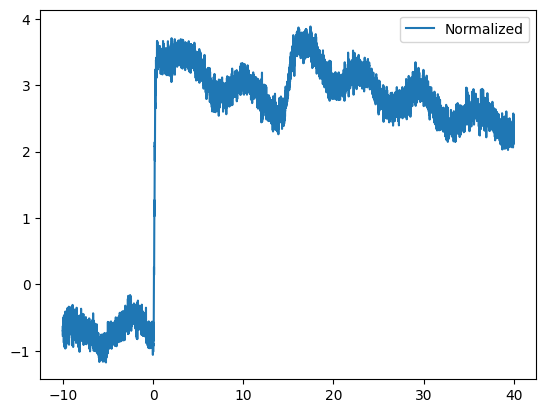

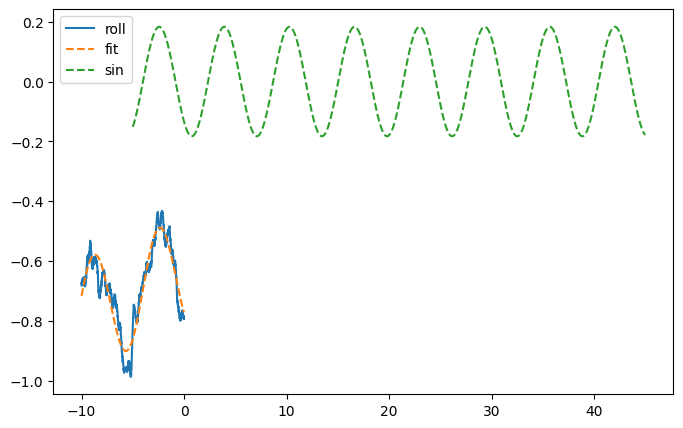

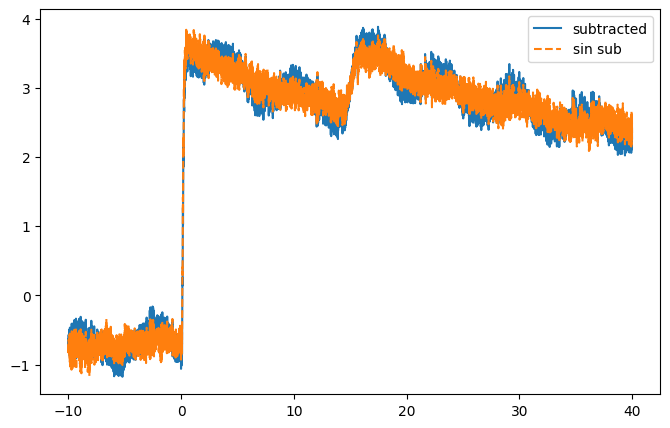

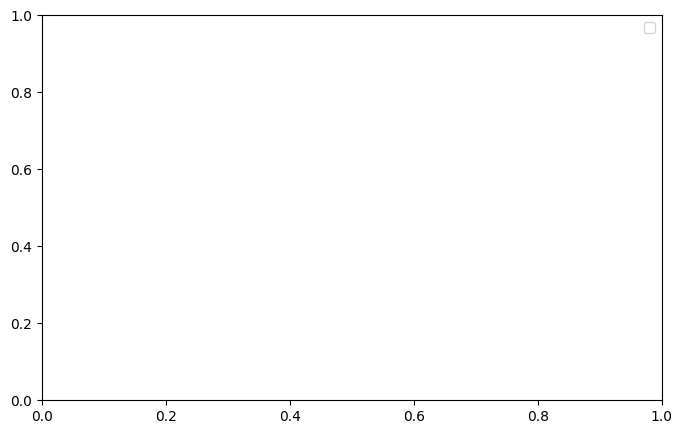

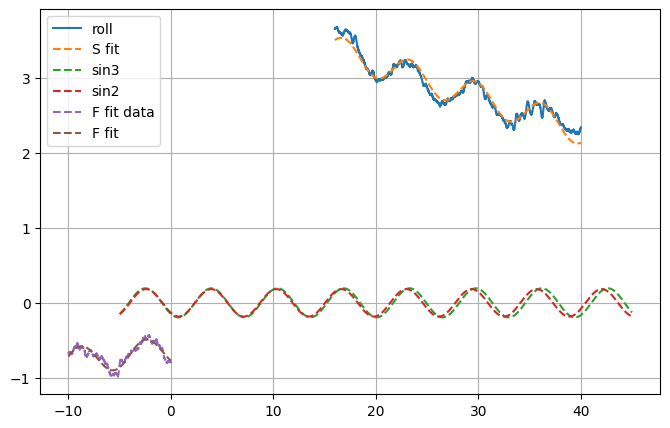

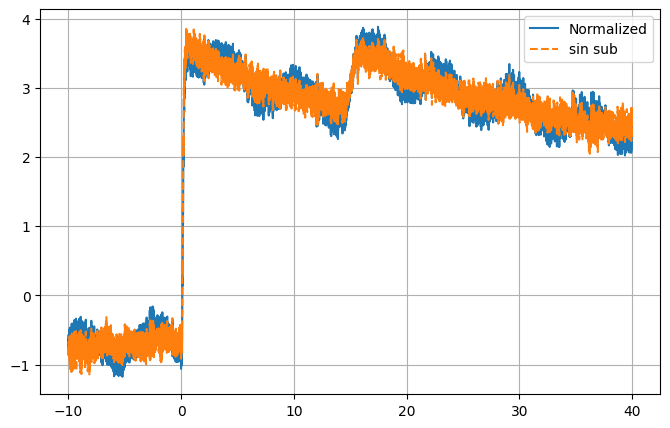

In [316]:
run=333
DF=GetWaveForm(GetBGRun(run))

norm=np.average(DF["Avg Anode"][1500:2511])



zero=2511



print("norm ", norm)
lbity=DF["Avg Anode"][zero+1500:]-norm
lbity=lbity.rolling(1000,min_periods=1).mean()
lbitx=DF["Time"][zero+1500:]

y=np.concatenate([DF["Avg Anode"][:zero+1500]-norm,lbity])
x=np.concatenate([DF["Time"][:zero+1500],lbitx])


y=np.zeros(len(y))

#plt.errorbar(x=lbitx,y=lbity)


DF=GetWaveForm(run)

normalized_sub = DF["Avg Anode"]-norm -y
plt.errorbar(x=DF["Time"],y=normalized_sub,label="Normalized")

fitstart= int(0/0.004)
fitend= int(10/0.004)
steps=1

x= DF["Time"][fitstart:fitend:steps]
y2=DF["Avg Anode"][fitstart:fitend:steps]-norm -y[fitstart:fitend:steps]
#plt.errorbar(x=x,y=y2,label="subtracted for fit")

plt.legend()

fig, ax = plt.subplots( figsize=(8,5))


x= DF["Time"][fitstart:fitend:]
y1=DF["Avg Anode"][fitstart:fitend:]-norm -y[fitstart:fitend:]
y1=y2.rolling(50,min_periods=1,center=True).mean()

plt.errorbar(x=x,y=y1,label="roll")


ffit_datay=y1
ffit_datax=x


def sin_linear(x, amplitude, frequency, phase, slope, intercept):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + slope * x + intercept
def sin(x, amplitude, frequency, phase ):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)


p0=[max(y1)-min(y1),0.15,0.1,-0.1,2]
bounds=[[p0[0]*0.1,0.001,-np.pi,-1,-10],[p0[0]*1.5,1.5,np.pi,1,50]]
params, covariance = curve_fit(sin_linear, x, y1,p0=p0,bounds=bounds)
params1=params
x_sin2=np.arange(-5,45,0.01)

sin_2=sin(x_sin2, params[0],params[1],params[2])

print(p0)
fity = sin_linear(x, *params)

ffity=fity
ffitx=x

plt.errorbar(x=x,y=fity,fmt="--",label="fit")
plt.errorbar(x=x_sin2,y=sin_2,fmt="--",label="sin")
plt.legend()

fig, ax = plt.subplots( figsize=(8,5))

plt.errorbar(x=DF["Time"],y=DF["Avg Anode"]-norm -y,label="subtracted")
plt.errorbar(x=DF["Time"],y=(DF["Avg Anode"]-norm -y)-sin(DF["Time"],params[0],params[1],params[2]),fmt="--",label="sin sub")

#print(np.round(params,12))
print(params)
print((covariance))
plt.legend()
#plt.xlim(15)

fig, ax = plt.subplots( figsize=(8,5))

fitstart= int(26/0.004)
fitend= int(60/0.004)
steps=1

x= DF["Time"][fitstart:fitend:steps]
y2=DF["Avg Anode"][fitstart:fitend:steps]-norm -y[fitstart:fitend:steps]


plt.legend()

fig, ax = plt.subplots( figsize=(8,5))


x= DF["Time"][fitstart:fitend:]
y1=DF["Avg Anode"][fitstart:fitend:]-norm -y[fitstart:fitend:]
y1=y2.rolling(50,min_periods=1,center=True).mean()
plt.errorbar(x=x,y=y1,label="roll")


p0=[max(y1)-min(y1),0.15,0.1,-0.1,2]
bounds=[[p0[0]*0.1,0.001,-np.pi,-1,-10],[p0[0]*1.5,1.5,np.pi,1,50]]
params, covariance = curve_fit(sin_linear, x, y1,p0=p0,bounds=bounds)

x_sin2=np.arange(-5,45,0.01)

sin_3=sin(x_sin2, params[0],params[1],params[2])

print(p0)
fity = sin_linear(x, *params)

plt.errorbar(x=x,y=fity,fmt="--",label="S fit")
plt.errorbar(x=x_sin2,y=sin_3,fmt="--",label="sin3")
plt.errorbar(x=x_sin2,y=sin_2,fmt="--",label="sin2")
plt.errorbar(ffit_datax,ffit_datay,fmt="--",label="F fit data")
plt.errorbar(ffitx,ffity,fmt="--",label="F fit")

plt.legend()
plt.grid()
fig, ax = plt.subplots( figsize=(8,5))

plt.errorbar(x=DF["Time"],y=DF["Avg Anode"]-norm ,label="Normalized")
plt.errorbar(x=DF["Time"],y=(DF["Avg Anode"]-norm -y)-sin(DF["Time"],params[0],params[1],params[2]),fmt="--",label="sin sub")

#print(np.round(params,12))
print(params)
print((covariance))
plt.legend()
plt.grid()
#plt.xlim(15)



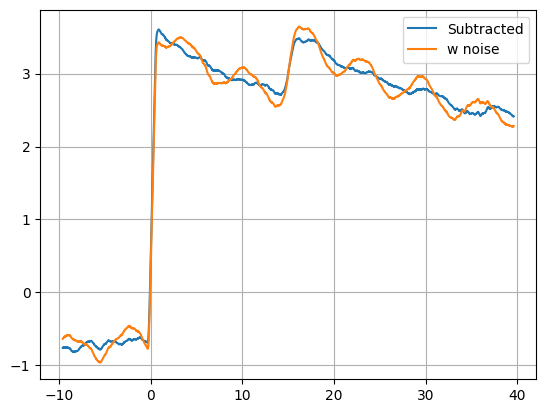

In [21]:
newy= (DF["Avg Anode"]-norm -y)-sin(DF["Time"],params1[0],params1[1],params1[2])
x= DF["Time"]


yroll=newy.rolling(200,center=True).mean()
yroll_old= np.convolve(DF["Avg Anode"]-norm, np.ones(200)/200,mode="same")
#plt.errorbar(x,newy)
plt.errorbar(x,yroll,label="Subtracted")
plt.errorbar(x[100:-100],yroll_old[100:-100],label="w noise")
plt.legend()
plt.grid()

In [666]:
def GetSinBG(x_data,y_data,time_start=0,time_stop=10,stepsize=100,debug=10,plot=True):
    
    x_fit=[]
    y_fit=[]
    
    if len(x_data) <=1 or len(y_data)<=1 or len(x_data) != len(y_data):

        print("X and Y need to be equal in length and need two more data points")
        print(" X: ", len(x_data), " Y :" ,len(y_data))
        return np.zeros(len(x)),np.zeros(len(y))
    
    if plot: sin_figure, sin_ax =plt.subplots(figsize=(5,4))

    # Determine fitting limits
    time_resolution= x_data[1] - x_data[0]
    index_start = int(time_start/time_resolution)
    index_stop = int(time_stop/time_resolution)
    if debug>=10: print("Start ",time_start,index_start," stop ",time_stop,index_stop)
    
    if plot:sin_ax.errorbar(x_data,y_data,alpha=0.75,
    linestyle=(0, (5, 1)),c="grey",label="Data")



    # smooth out the data
    smooth_slice=slice(int(stepsize/2),-(int(stepsize/2)+1))
    smooth_ydata=np.convolve(y_data,
     np.ones(stepsize)/stepsize,mode="same")[smooth_slice]
    smooth_xdata=x_data[smooth_slice]
    if plot:sin_ax.errorbar(smooth_xdata,smooth_ydata,
    linestyle=(0, (5, 1)),label="Smooth Data")

    # Prepare for fit
    x_fitdata=smooth_xdata[index_start:index_stop-int(stepsize/2)]
    y_fitdata=smooth_ydata[index_start:index_stop-int(stepsize/2)]
    if plot:sin_ax.errorbar(x_fitdata,y_fitdata,fmt=":",label="Fit Data")

    p0=[max(y_fitdata)-min(y_fitdata),0.15,0.1,-0.1,2]
    bounds=[0,0.001,-np.pi,-1,-10],[p0[0],1.5,np.pi,1,50]
    
    if debug>=10:
        print("Fit P0",p0)
        print("Bounds",bounds)
    params, covariance = curve_fit(sin_linear, 
        x_fitdata, y_fitdata,p0=p0,bounds=bounds)

    if debug >=5:
        print("Parameters", params)
    if debug>=10: print("Covariance",covariance)
    
    x_fit=smooth_xdata
    y_fit=sin(x_fit,params[0],params[1],params[2])
    if plot:
        sin_ax.errorbar(x_fitdata,sin_linear(x_fitdata,*params),
        linestyle="--",label="Fit Results")
        sin_ax.errorbar(x_fit,y_fit,linestyle="--",label="Sin Fit")
        sin_ax.errorbar(x_fit,smooth_ydata-y_fit,alpha=0.75,fmt="-.",label="Subtracted")
    
    
    
    if plot:
        sin_ax.grid()
        sin_ax.legend()

    return params,covariance

[1479 1480 1481 1482 1483 1484 1485 1486 1490 1491 1492 1493 1494 1495
 1496 1497 1504 1505 1506] [904 905 906 907 908 909 910 911 912 913 914 915 916 917]
[1465, 1839]
4.309422925641713
1.03596823251163


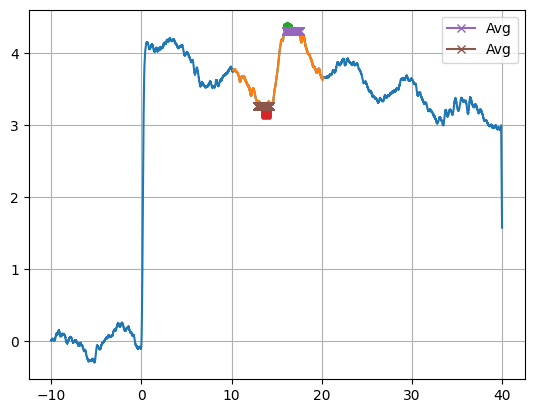

In [336]:
DF=GetWaveForm(333)
stepcount=50

Anode=np.convolve(DF["Avg Anode"]-np.average(DF["Avg Anode"][0:2000]),np.ones(stepcount)/stepcount,mode="same")
Time=DF["Time"]

delaytime=15.2

t1=np.where(abs(Time-delaytime)<5)[0][0]
t2=np.where(abs(Time-delaytime)<5)[0][-1]
max_anodesig=np.max(Anode[t1:t2])
min_anodesig=np.min(Anode[t1:t2])
index_max =np.where(abs(Anode[t1:t2]-max_anodesig)<0.01)[0]
index_min =np.where(abs(Anode[t1:t2]-min_anodesig)<0.01)[0]

print(index_max,index_min)

t_min=Time[index_min]
t_max=Time[index_max]

index_min_avg=np.average(index_min)
index_max_avg=np.average(index_max)

index_min_spread=[int(index_min_avg-int(1/0.004)),int(np.min(index_min+int(0.5/0.004)))]
index_max_spread=[int(index_max_avg-int(0.1/0.004)),int(index_max_avg+int(1.4/0.004))]
print(index_max_spread)
max_avg=np.average(Anode[index_max_spread[0]+t1:index_max_spread[1]+t1])
print(max_avg)
min_avg=np.average(Anode[index_min_spread[0]+t1:index_min_spread[1]+t1])


plt.errorbar(Time, Anode)

plt.errorbar(Time[t1:t2], Anode[t1:t2])

plt.errorbar(Time[t1+index_max],Anode[t1+index_max],fmt=" ",marker="h")
plt.errorbar(Time[t1+index_min],Anode[t1+index_min],fmt=" ",marker="s")


plt.errorbar(y=np.ones(len(Time[index_max_spread[0]+t1:index_max_spread[1]+t1]))*max_avg,
                       x=Time[index_max_spread[0]+t1:index_max_spread[1]+t1],marker="x",
                       label="Avg")


plt.errorbar(y=np.ones(len(Time[index_min_spread[0]+t1:index_min_spread[1]+t1]))*min_avg,
                       x=Time[index_min_spread[0]+t1:index_min_spread[1]+t1],marker="x",
                       label="Avg")


print(max_avg-min_avg)

plt.grid()

plt.legend()


In [189]:
def FindAmpDiff(x,y,step_location,stepsize=10,windowsize=10,debug=1,plot=True):

    # zoom into area of intrest
    t1=np.where(abs(x-step_location)<windowsize/2)[0][0]
    t2=np.where(abs(x-step_location)<windowsize/2)[0][-1]
    time_resolution = x[1]-x[0]

    localmax=np.max(y[t1:t2])
    localmin=np.min(y[t1:t2])
    index_max =np.where(abs(y[t1:t2]-localmax)<0.01)[0]
    index_min =np.where(abs(y[t1:t2]-localmin)<0.01)[0]


    if debug >=10:
        print("Min ",localmin, " max ",localmax)
        print(index_max,index_min)
    

    if plot: 
        fig,ax =plt.subplots(figsize=(5,4))
        ax.errorbar(x[t1:t2],y[t1:t2],label="Data")
        ax.errorbar(x=x[index_max+t1],y=y[index_max+t1],marker="s",label="Max")
        ax.errorbar(x=x[index_min+t1],y=y[index_min+t1],marker="s",label="Min")

        ax.grid()
        ax.legend()



Min  30.83117  max  32.45448
[2114] [1225]


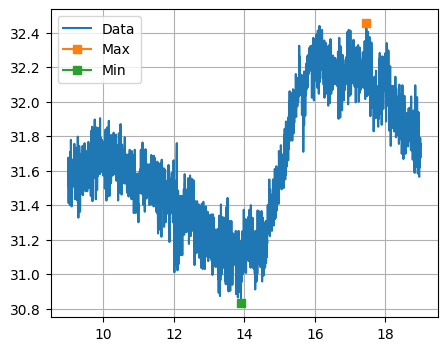

In [337]:
DF=GetWaveForm(333)
FindAmpDiff(DF["Time"],DF["Avg Anode"],14,stepsize=200,debug=10)

In [526]:
# Moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


In [ ]:
# Generate a list of colors from a colormap
cmap = plt.cm.viridis  # Replace with your desired colormap
num_colors = 10
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]

Sept  2.4
diff  0.004
[7.11383996 2.09591781 0.61351393]
[7.09082829 2.09755228 0.61411908]
[7.04977695 2.09990449 0.61510595]
[6.87379373 2.11045802 0.61944182]
[6.57669455 2.12983813 0.62712501]
[6.15671381 2.1606016  0.63878163]
[4.96554565 2.27205787 0.6775734 ]


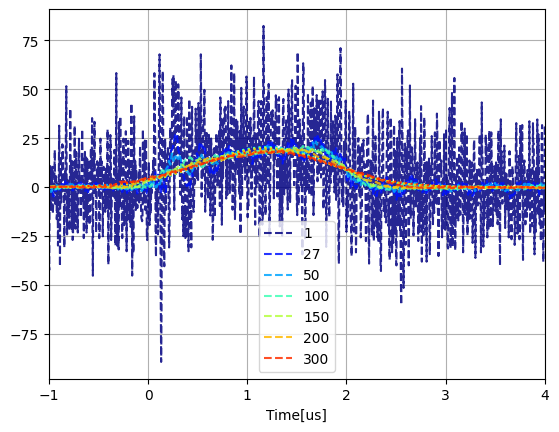

In [799]:
DF=GetWaveForm(333)

Cath_norm = DF["Avg Cathode"]-np.average(DF["Avg Cathode"][0:int(8/0.004)])
time = DF["Time"]

diffsize=1
stepcount=600
print("Sept ",stepcount*0.004)
print("diff ",diffsize*0.004)

params,cov = GetSinBG(time,-Cath_norm,12,48,debug=1,plot=False)
sinbg=sin(time,params[0],params[1],params[2])


cleancath= Cath_norm+sinbg




stepcounts  =  [1,27,50,100,150,200,300]


cmap = plt.cm.jet  # Replace with your desired colormap
num_colors = len(stepcounts)+1

colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
fig,ax=plt.subplots()
for i,stepcount in enumerate([1,27,50,100,150,200,300]):
    smooth_cleancath=moving_average(cleancath,stepcount)
    smooth_time=moving_average(time,stepcount)


    

    diff= np.gradient(-smooth_cleancath[::diffsize],smooth_time[::diffsize]
                      )
    #plt.errorbar(y=-smooth_cleancath,marker=".",x=smooth_time,alpha=0.5)
    plt.errorbar(y=diff,x=smooth_time[::diffsize],alpha=0.85,
                 c=colors[i],fmt="--",label=stepcount)


    fit_datax=smooth_time[::diffsize]
    fit_datay=diff

    params,covar = curve_fit(congaussian,fit_datax,fit_datay)

    print(params)

    fitx= np.arange(-1,4,0.1)
    fity= congaussian(fitx,*params)

    plt.errorbar(fitx,fity,fmt=":",c=colors[i])






diff2 = np.gradient(-Cath_norm[::diffsize],time[::diffsize])




# plt.errorbar(y=-Cath_norm[::stepsize],x=time[::stepsize])
#plt.errorbar(y=-Cath_norm,x=time,alpha=0.5,label="")







#plt.legend()
#plt.grid()
#plt.xlabel("Time[us]")
#plt.xlim(-3,8)


# plt.close()
#fig,ax=plt.subplots()
#plt.errorbar(y=diff2,x=time[::diffsize],label="Raw")


#plt.ylim(5,20)
plt.xlim(-1,4)
peakind=np.where(diff>=np.max(diff)*0.5)[0]
peak_diff=diff[peakind]
peak_time=smooth_time[peakind*diffsize]
# plt.errorbar(peak_time,peak_diff,label="peak")


plt.grid()
plt.xlabel("Time[us]")
plt.legend()

In [613]:

smooth_time[np.where(diff>=np.max(diff)*0.2)[0]]

array([-9.12999969, -9.12599969, -9.12199969, -9.11799969, -9.11399969,
       -9.10999969, -9.10599969, -9.10199969, -9.09799969, -9.09399969,
       -9.08999969, -9.08599969, -9.08199969, -9.07799969, -9.07399969,
       -9.06999969, -9.06599969, -9.06199969, -9.05799969, -9.05399969,
       -9.04999969, -9.04599969, -9.04199969, -9.03799969, -9.03399969,
       -9.02999969, -9.02599969, -9.02199969])